# Neural Machine Translation using Seq2Seq Modelling using PyTorch
- https://colab.research.google.com/github/bala-codes/Natural-Language-Processing-NLP/blob/master/Neural%20Machine%20Translation/1.%20Seq2Seq%20%5BEnc%20%2B%20Dec%5D%20Model%20for%20Neural%20Machine%20Translation%20%28Without%20Attention%20Mechanism%29.ipynb#scrollTo=hxGjrP6hWeB9
- German to English neural machine translation

Table of Contents:
1. Introduction
1. Data Preparation and Pre-processing
1. Long Short Term Memory (LSTM) - Under the Hood
1. Encoder Model Architecture (Seq2Seq)
1. Encoder Code Implementation (Seq2Seq)
1. Decoder Model Architecture (Seq2Seq)
1. Decoder Code Implementation (Seq2Seq)
1. Seq2Seq (Encoder + Decoder) Interface
1. Seq2Seq (Encoder + Decoder) Code Implementation
1. Seq2Seq Model Training
1. Seq2Seq Model Inference

### 1. Introduction
- LSTM : the encoder neural network encodes the input german sequence into a single vector(Context Vector).
    - This ***Context Vector*** is said to contain the ***abstract representation of the input german sequence***.
- This vector is then passed into the decoder neural network, which is used to output the corresponding English translation sentence, one word at a time.

#### Necessary Imports

In [159]:
# !pip install tensorboard
# !pip install torchsummary
# !pip install torchtext==0.6.0 --quiet
# !pip install nltk

In [160]:
import torch
import torch.nn as nn
import torch.optim as optim
# from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
import numpy as np
import pandas as pd
import spacy
import random
from torchtext.data.metrics import bleu_score
from pprint import pprint
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

# Seeding for reproducible results everytime
SEED = 777

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### 2. Data Preparation & Pre-processing

In [161]:
# !python -m spacy download en --quiet
# !python -m spacy download de --quiet

In [162]:
# spacy_german = spacy.load("de_core_news_sm")
spacy_german = spacy.load("fr_core_news_sm")
spacy_english = spacy.load("en_core_web_sm")

- let's create custom tokenization methods for the languages.
    - breaking the sentence into a list of individual tokens (words)
- PyTorch's TorchText library for data pre-processing and SpaCy for vocabulary building (English and German) & tokenization of our data.

In [163]:
def tokenize_german(text):
  return [token.text for token in spacy_german.tokenizer(text)]

def tokenize_english(text):
  return [token.text for token in spacy_english.tokenizer(text)]

### Sample Run ###
sample_text = "I love machine learning"
print(tokenize_english(sample_text))

['I', 'love', 'machine', 'learning']


- __Torch text__ for making the text data ready for variety of NLP tasks
    - preprocessing tools
- process
    1. Train/ Valid/ Test Split
    1. File Loading: load the text corpus of various formats (.txt,.json,.csv).
    1. Tokenization
    1. Vocab: Generate a list of vocabulary from the text corpus.
    1. Words to Integer Mapper: Map words into integer numbers for the entire corpus and vice versa.
    1. Word Vector: Convert a word from higher dimension to lower dimension (Word Embedding).
    1. Batching: Generate batches of sample.

Here we are going to make use of __3 classes under torch text__.
1. Fields :
> specify how the preprocessing should be done on our data corpus.
1. TabularDataset :
> define the Dataset of columns stored in CSV, TSV, or JSON format and also map them into integers.
1. BucketIterator :
> padding and make batches with our data for model training.

In [164]:
# https://github.com/multi30k/dataset/tree/master
# filepath = '/data/hwyu/data/multi30k/'

# train_en_path = filepath+"train.lc.norm.tok.en"
# train_de_path = filepath+"train.lc.norm.tok.de"
# test_eng_path = filepath+"test_2017_flickr.lc.norm.tok.en"
# test_de_path = filepath+"test_2017_flickr.lc.norm.tok.de"

In [165]:
# 위와 비교해봤는데 몇 개 문장 출력해봤을 때는 동일한데 단어 집합 빈도 살짝 달랐음
# 그리고 이거 써도 반점부터 다 날아감 
# filepath = '/data/hwyu/data/multi30k/not_tok/'

# train_en_path = filepath+"train.en"
# train_de_path = filepath+"train.de"
# test_eng_path = filepath+"test_2017_flickr.en"
# test_de_path = filepath+"test_2017_flickr.de"

In [166]:
# https://zenodo.org/records/6482585#.YsmVBUhBxkg
filepath = '/data/hwyu/data/libri/'

# ?? 왜 여러 문장이 한 문장 취급되지?? tsv떄문인가 
train_en_path = filepath+"train/train.en"
# train_de_path = filepath+"train/train.fr" # gtranslate가 더 정확한 듯 
train_de_path = filepath+"train/train_gtranslate.fr" 

train_oth_en_path = filepath+"train/other.en"
# train_de_path = filepath+"train/other.fr"
train_oth_de_path = filepath+"train/other_gtranslate.fr" 

test_eng_path = filepath+"test/test.en"
# test_de_path = filepath+"test/test.fr"
test_de_path = filepath+"test/test_gtranslate.fr"

In [167]:
end_line = 100000  # 끝 라인 (포함하지 않음)

train_en_sub_raw = []  # 추출한 데이터를 저장할 리스트

with open(train_en_path, "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        train_en_sub_raw.append(line.strip())
        if i + 1 >= end_line:
            break

with open(train_oth_en_path, "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        train_en_sub_raw.append(line.strip())
        if i + 1 >= end_line:
            break
            
limit_data_len = 120000
train_en_sub_raw = train_en_sub_raw[:limit_data_len]
# 데이터 확인
print(len(train_en_sub_raw))
print(train_en_sub_raw[:10])

108640
['ADIEU VALENTINE ADIEU', 'PROVE IT DANGLARS', 'SAID FRANZ', 'SAID FRANZ', 'FERNAND MONDEGO', 'AND THE CORRIDOR', 'FOR ANDREA RONDOLO', 'FOR ANDREA RONDOLO', 'SAID FERNAND', 'SAID ANDREA']


In [168]:
train_fr_sub_raw = []

with open(train_de_path, "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        train_fr_sub_raw.append(line.strip())
        if i + 1 >= end_line:
            break

with open(train_oth_de_path, "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        train_fr_sub_raw.append(line.strip())
        if i + 1 >= end_line:
            break
train_fr_sub_raw = train_fr_sub_raw[:limit_data_len]
# 데이터 확인
print(len(train_fr_sub_raw))
print(train_fr_sub_raw[:10])

108640
['"Adieu, Valentine, adieux!', 'Prouve, Danglars.', 'Dit Franz.', 'Dit Franz.', '"" Fernand Mondego.', '"" Et le couloir?', '"" Pour Andrea Rondolo?', '"" Pour Andrea Rondolo?', '"A déclaré Fernand.', '"Dit Andrea.']


In [169]:
with open(test_eng_path, "r", encoding="utf-8") as file:
    test_en_raw = file.readlines()
    
with open(test_de_path, "r", encoding="utf-8") as file:
    test_fr_raw = file.readlines()

# 데이터 확인 ?? 각 문장 끝 줄바꿈 지워야 하나, 프랑스어 대쉬 지워야하나
print(len(test_en_raw))
print(len(test_fr_raw))
print(test_en_raw[:2])
print(test_fr_raw[:2])

2048
2048
['IN ANOTHER THE GROUND WAS CUMBERED WITH RUSTY IRON MONSTERS OF STEAM BOILERS WHEELS CRANKS PIPES FURNACES PADDLES ANCHORS DIVING BELLS WINDMILL SAILS AND I KNOW NOT WHAT STRANGE OBJECTS ACCUMULATED BY SOME SPECULATOR AND GROVELLING IN THE DUST UNDERNEATH WHICH HAVING SUNK INTO THE SOIL OF THEIR OWN WEIGHT IN WET WEATHER THEY HAD THE APPEARANCE OF VAINLY TRYING TO HIDE THEMSELVES\n', 'THE CLASH AND GLARE OF SUNDRY FIERY WORKS UPON THE RIVER SIDE AROSE BY NIGHT TO DISTURB EVERYTHING EXCEPT THE HEAVY AND UNBROKEN SMOKE THAT POURED OUT OF THEIR CHIMNEYS\n']
["Dans un autre, le terrain était encombré de monstres en fer rouillé de chaudières à vapeur, de roues, de manivelles, de tuyaux, de fours, de pagaies, d'ancrages, de cloches, de voiliers, et je ne sais pas quels objets étranges, accumulés par un spéculateur, et Se creusant dans la poussière, sous laquelle - s'étant enfoncée dans le sol de leur propre poids par temps humide - ils avaient l'apparence d'essayer vainement de se

In [170]:
# with open(train_en_path, 'r') as file:
#     # 파일의 각 줄에 대해 반복
#     for line in file:
#         # 각 줄에서 \t 문자의 인덱스 찾기
#         tab_index = line.find('\t')
#         if tab_index != -1:
#             print(f"탭 문자는 {tab_index}번째 위치에 있습니다.")

In [171]:
from unicodedata import normalize

def unicodeToAscii(s):
    return normalize('NFD', s).encode('ascii', 'ignore').decode('utf-8')

def normalizeString(s):
    return unicodeToAscii(s.lower())

def normalizeStrings(lines):
    return [normalizeString(s) for s in lines]

def check_characters_in_file(lines):

    # 각 문장에 포함된 모든 문자를 저장할 빈 세트를 생성
    all_characters = set()

    # 각 문장을 반복하면서 문자를 세트에 추가
    for line in lines:
        # 개행 문자 및 불필요한 공백 제거
        line = line.strip()
        # 문장에 포함된 모든 문자를 세트에 추가
        all_characters.update(set(line))

    return all_characters
# characters_in_file = check_characters_in_file(normalizeStrings(test_fr_raw))
characters_in_file = check_characters_in_file(normalizeStrings(train_fr_sub_raw)) # other_gtranslatefr : 모든 알파벳과 숫자, ')}_%+?&:"/-{[(.,;*!$[, 스페이 
print("파일에 포함된 모든 문자:", characters_in_file)

파일에 포함된 모든 문자: {'[', 'l', ';', '8', 'q', 'o', 'r', "'", '*', '%', 'v', '!', '&', '?', ',', 'p', 'x', '+', 'a', 'y', 'h', '_', '9', ' ', 'm', '}', '(', 'k', ')', '.', '6', '7', 'e', '"', 'f', 'z', 'n', '{', '0', ']', '1', '/', '2', '3', 'g', 'j', '4', 'u', '5', 'i', 't', 'd', '-', 'w', ':', '$', 'c', 's', 'b'}


In [172]:
def check_characters_in_file(file_path):
    # 파일을 열고 모든 내용을 읽어들임
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # 각 문장에 포함된 모든 문자를 저장할 빈 세트를 생성
    all_characters = set()

    # 각 문장을 반복하면서 문자를 세트에 추가
    for line in lines:
        # 개행 문자 및 불필요한 공백 제거
        line = line.strip()
        # 문장에 포함된 모든 문자를 세트에 추가
        all_characters.update(set(line))

    return all_characters

# 파일에서 사용된 모든 문자 확인
# characters_in_file = check_characters_in_file(test_eng_path) # 알파벳(모두)과 스페이스 밖에 없음 
# characters_in_file = check_characters_in_file(test_de_path) # 숫자는 7, 9 없음 / 스페이스랑 * ) . ; : ! ? $ - " , ' (

# train.en 은 작은 따옴표 없애서 dont, thats 이런 식으로 돼있고 other.en은 작은 따옴표 있어서 don't, that's 이렇게 돼있음(thats도 있긴험)
characters_in_file = check_characters_in_file(train_en_path) # 알파벳(모두), 숫자(모두), 스페이스
# characters_in_file = check_characters_in_file(train_de_path) # 알파벳(모두), 숫자(모두), 스페이스, * [ ) . ; : ! ? $ ] - " , & ' , _ 
print("파일에 포함된 모든 문자:", characters_in_file)

파일에 포함된 모든 문자: {'K', 'F', 'T', '7', 'X', '8', '6', 'J', 'G', 'B', '0', 'S', 'Y', '1', 'Q', '2', '3', 'D', 'C', 'V', '4', 'R', 'H', 'L', 'P', '5', 'U', 'E', 'N', 'O', 'Z', 'W', '9', ' ', 'A', 'I', 'M'}


In [173]:
# print(train_fr_sub_raw[550])
# print()
# print(train_fr_g_sub_raw[550]) # en과 동일
# print()
# print(train_en_sub_raw[550]) # train_fr_sub_raw[550] 의 콜론 이후는 번역x

# 의미는 같은데 fr의 ; : 가 en에 없음 
# print(train_fr_sub_raw[616])
# print()
# print(train_fr_g_sub_raw[616])
# print()
# print(train_en_sub_raw[616])

# print(train_fr_sub_raw[702])
# print(train_en_sub_raw[702]) # fr의 숫자를 영어로 씀 

# ?? 숫자 뭐지 
# print(train_fr_sub_raw[3135]) # « Six cent mille?
# print()
# print(train_fr_g_sub_raw[3135]) # ~~~ 700 000 000 000
# print()
# print(train_en_sub_raw[3135]) # SIX HUNDRED THOUSAND700000800000

# print(train_fr_sub_raw[11486])
# print()
# print(train_fr_g_sub_raw[11486]) # en 처럼 3651364
# print()
# print(train_en_sub_raw[11486]) # HIM 옆에 의미없는 3651364 가 붙어있음  

print(train_fr_sub_raw[4191]) # 이것만 문장 더 있고 g trans가 맞음
print()
# print(train_fr_g_sub_raw[4191])
# print()
print(train_en_sub_raw[4191])

Puis enfermant le reçu de monte cristos dans un petit livre de poche, il ajouta que oui, à 12 heures, je serai loin, puis il double verrouillé sa porte vide tous ses tiroirs recueillis environ cinquante mille francs en billets de banque ont brûlé plusieurs papiers laissés à d'autres exposés à la vue1876

THEN ENCLOSING MONTE CRISTOS RECEIPT IN A LITTLE POCKET BOOK HE ADDED YES COME AT TWELVE OCLOCK I SHALL THEN BE FAR AWAY THEN HE DOUBLE LOCKED HIS DOOR EMPTIED ALL HIS DRAWERS COLLECTED ABOUT FIFTY THOUSAND FRANCS IN BANK NOTES BURNED SEVERAL PAPERS LEFT OTHERS EXPOSED TO VIEW1876


In [174]:
import unicodedata
from unicodedata import normalize
import re

# def unicodeToAscii(s):
#     # return ''.join( # 악센트 있는 문자 통째로 제거
#     #     c for c in unicodedata.normalize('NFD', s)
#     #     if unicodedata.category(c) != 'Mn'
#     # )
#     # 악센트만 제거
#     return normalize('NFD', s).encode('ascii', 'ignore').decode('utf-8')

def normalizeString(s):
    # s = unicodeToAscii(s.lower().strip())
    s = unicodeToAscii(s)
    # s = re.sub(r"([.!?\"])", r" \1", s) # 마침표, 느낌표, 물음표, 따옴표 앞에 공백을 추가
    # s = re.sub(r"[^a-zA-Z.!?]+", r" ", s) # G 영문 알파벳과 마침표(.), 느낌표(!), 물음표(?)를 제외한 모든 문자를 공백으로 대체/ +: 해당 패턴이 한 번 이상 반복
    s = re.sub(r"[^a-zA-Z]+", r" ", s) # 이 코드 실행 후 strip() 안하면 문장 앞뒤 제거됐을 때 공백생김 
    return s.strip()

print(train_fr_sub_raw[2222]) 
print(normalizeString(train_fr_sub_raw[2222]))

print(train_fr_sub_raw[3332]) 
print(normalizeString(train_fr_sub_raw[3332]))

Oh, Beauchamp, Beauchamp, comment puis-je aborder le mien?
Oh Beauchamp Beauchamp comment puis je aborder le mien
Mais, après m'avoir péché, peut-être plus profondément que d'autres, je ne me reposerai jamais avant d'avoir déchiré les semblables de mes semblables et j'ai découvert leurs faiblesses. Je les ai toujours trouvés; Et plus encore, je le répète avec joie, avec triomphe, j'ai toujours trouvé une preuve de perversité humaine ou d'erreur.
Mais apres m avoir peche peut etre plus profondement que d autres je ne me reposerai jamais avant d avoir dechire les semblables de mes semblables et j ai decouvert leurs faiblesses Je les ai toujours trouves Et plus encore je le repete avec joie avec triomphe j ai toujours trouve une preuve de perversite humaine ou d erreur


In [175]:
def normalizeStrings(lines):
    return [normalizeString(s) for s in lines]
    
train_fr_sub = normalizeStrings(train_fr_sub_raw)
train_en_sub = normalizeStrings(train_en_sub_raw)
test_fr = normalizeStrings(test_fr_raw)
test_en = normalizeStrings(test_en_raw)

In [176]:
print(train_fr_sub[100:105])
print(train_fr_sub_raw[100:105])
print()

# print(train_en_sub[1000:1005])
# print(train_en_sub_raw[1000:1005])
# print()

# print(test_fr[100:105])
# print(test_fr_raw[100:105])
# print()

# print(test_en[100:105])
# print(test_en_raw[100:105])

['Le celebre Cucumetto poursuivi dans les Abruzzes chasse du royaume de Naples ou il avait mene une guerre reguliere avait traverse le Garigliano comme Manfred et s etait refugie sur les rives de l Amasine entre Sonnino et Juperno', 'Vous connaissez les environs de Paris alors', 'Vous connaissez les environs de Paris alors', 'Franz prit la lampe et entra dans la grotte souterraine suivie de Gaetano', 'Gaetano ne se trompait pas']
['"Le célèbre Cucumetto, poursuivi dans les Abruzzes, chassé du royaume de Naples, où il avait mené une guerre régulière, avait traversé le Garigliano, comme Manfred, et s\'était réfugié sur les rives de l\'Amasine entre Sonnino et Juperno.', '"" Vous connaissez les environs de Paris, alors?', '"" Vous connaissez les environs de Paris, alors?', 'Franz prit la lampe et entra dans la grotte souterraine, suivie de Gaetano.', 'Gaetano ne se trompait pas.']



In [177]:
# # from torchtext.data import TabularDataset

# # Field 정의
# # english = Field(tokenize='spacy', lower=True)
# # german = Field(tokenize='spacy', lower=True)

# n = 100  # 예시로 100개의 데이터만 사용하도록 설정

german = Field(tokenize=tokenize_german,
               lower=True,
               init_token="<sos>",
               eos_token="<eos>")

english = Field(tokenize=tokenize_english,
               lower=True,
               init_token="<sos>",
               eos_token="<eos>")

# # TabularDataset을 사용하여 데이터 로드
# # format=csv로 하면 문장에서 콤마부터 짤리는듯
# train_data = TabularDataset(
#     path=train_de_path,  # 영어 훈련 데이터 파일 경로
#     format='tsv',        # 데이터 포맷 (tsv) : Tab-Separated Values"를 의미합니다. 이는 각 열이 탭으로 구분된 텍스트 파일
#     fields=[('src', german)]  # 데이터 필드 지정
#     # num_lines=n  # 읽을 데이터의 개수 설정
# )

# # 독일어 훈련 데이터 로드 및 추가
# train_data.fields['trg'] = english
# train_en_data = TabularDataset(
#     path=train_en_path,  # 독일어 훈련 데이터 파일 경로
#     format='tsv',        # 데이터 포맷 (tsv)
#     fields=[('trg', english)]  # 데이터 필드 지정
#     # num_lines=n  # 읽을 데이터의 개수 설정
# )

# # 영어 훈련 데이터에 독일어 데이터 추가
# for i in range(len(train_data)):
#     train_data[i].trg = train_en_data[i].trg

# # 테스트 데이터 로드
# test_data = TabularDataset(
#     path=test_de_path,   # 영어 테스트 데이터 파일 경로
#     format='tsv',        # 데이터 포맷 (tsv)
#     fields=[('src', german)]  # 데이터 필드 지정
# )

# # 독일어 테스트 데이터 로드 및 추가
# test_data.fields['trg'] = english
# test_en_path = TabularDataset(
#     path=test_eng_path,   # 독일어 테스트 데이터 파일 경로
#     format='tsv',        # 데이터 포맷 (tsv)
#     fields=[('trg', english)]  # 데이터 필드 지정
# )

# # 영어 테스트 데이터에 독일어 데이터 추가
# for i in range(len(test_data)):
#     test_data[i].trg = test_en_path[i].trg

# # 단어 집합(Vocabulary) 구축
# german.build_vocab(train_data, max_size=10000, min_freq=3)
# english.build_vocab(train_data, max_size=10000, min_freq=3)

# # 단어 집합 내용 확인
# print(english.vocab.freqs.most_common(10))  # 가장 빈도가 높은 단어 20개 출력 
# print(german.vocab.freqs.most_common(10))  # 가장 빈도가 높은 단어 20개 출력 @콤마 있는지 확인

In [178]:
from torchtext.data import Dataset, Example

def create_dataset(text_list, field_name, field_obj):
    examples = [Example.fromlist([text], [(field_name, field_obj)]) for text in text_list]
    return Dataset(examples, fields=[(field_name, field_obj)])
# fields=[('src', SRC), ('trg', TRG)]

In [179]:
from torchtext.vocab import FastText, GloVe

flag_pretrained_emb = True

train_data = create_dataset(train_fr_sub, 'src', german)

train_data.fields['trg'] = english
train_en_data = create_dataset(train_en_sub, 'trg', english)

for i in range(len(train_data)):
    train_data[i].trg = train_en_data[i].trg

test_data = create_dataset(test_fr, 'src', german)

test_data.fields['trg'] = english
test_en_path = create_dataset(test_en, 'trg', english)

for i in range(len(test_data)):
    test_data[i].trg = test_en_path[i].trg

max_vocab_size = 10000 # 14000
if flag_pretrained_emb :
    # 미리 훈련된 FastText 단어 임베딩 로드
    # fr_pretrained_emb = FastText(language="fr")
    # fr_pretrained_emb = FastText(language="fr", dim=300) # 300(default), 100, 50
    # en_pretrained_emb = FastText(language="en")
    
    # torch.save(fr_pretrained_emb, 'fr_fasttext.pt')
    # torch.save(en_pretrained_emb, 'en_fasttext.pt')

    # G cache_dir : 디렉토리가 존재하지 않는 경우에는 자동으로 생성
    ## fr_pretrained_emb = GloVe(name='6B', dim=300) # name: 42B, 840B, 6B
    # print("loading fr_pretrained_emb. . .")
    # fr_pretrained_emb = GloVe(name='6B', dim=300, cache='cache_dir_fr') # 텍스트가 6억 단어로 훈련된 것 / 50, 100, 200, 300
    # print("loading en_pretrained_emb. . .")
    # en_pretrained_emb = GloVe(name='6B', dim=300, cache='cache_dir_en')
    
    print("loading fr_fasttext. . .")
    fr_pretrained_emb = torch.load('fr_fasttext_dim300.pt')
    print("loading en_fasttext. . .")
    en_pretrained_emb = torch.load('en_fasttext_dim300.pt')
    
    print("load 완료\n")

    # fr.vec : 프랑스어 단어를 위한 임베딩 파일 
    # german.build_vocab(train_data, max_size=10000, min_freq=3, vectors="fr.vec")
    german.build_vocab(train_data, max_size=max_vocab_size, min_freq=3, vectors=fr_pretrained_emb)
    english.build_vocab(train_data, max_size=max_vocab_size, min_freq=3, vectors=en_pretrained_emb)
    # german.build_vocab(train_data, min_freq=3, vectors=fr_pretrained_emb)
    # english.build_vocab(train_data, min_freq=3, vectors=en_pretrained_emb)
else :
    # 단어 집합(Vocabulary) 구축
    # G 주어진 데이터셋에서 각 필드의 단어를 추출하여 사전을 구축
    german.build_vocab(train_data, max_size=max_vocab_size, min_freq=3)
    english.build_vocab(train_data, max_size=max_vocab_size, min_freq=3)
    # german.build_vocab(train_data, min_freq=3)
    # english.build_vocab(train_data, min_freq=3)

# 단어 집합 내용 확인
print(english.vocab.freqs.most_common(10))
print(german.vocab.freqs.most_common(10)) # 가장 빈도가 높은 단어 20개 출력 @콤마 있는지 확인

loading fr_fasttext. . .
loading en_fasttext. . .
load 완료

[('the', 126323), ('and', 70427), ('of', 66460), ('to', 59303), ('a', 46156), ('in', 35956), ('i', 33435), ('he', 29097), ('that', 28314), ('was', 25627)]
[('de', 89949), ('a', 77983), ('et', 69842), ('la', 59383), ('le', 49746), ('il', 43426), ('l', 41416), ('que', 34252), ('un', 34044), ('les', 33987)]


In [180]:
fr_pretrained_emb.__dict__.keys()

dict_keys(['itos', 'stoi', 'vectors', 'dim', 'unk_init'])

In [181]:
for data in train_data:
    print(f"txt 파일 : {train_en_sub[0]}")
    print(data.trg) # ?? 왜 공백 
    print(f"txt 파일 : {train_fr_sub[0]}")
    print(data.src) 
    # print("German - ",*data.src, " Length - ", len(data.src))
    break

txt 파일 : ADIEU VALENTINE ADIEU
['adieu', 'valentine', 'adieu']
txt 파일 : Adieu Valentine adieux
['adieu', 'valentine', 'adieux']


In [182]:
# print(english.vocab.stoi)  # 단어를 정수로 매핑한 딕셔너리 출력
print(list(german.vocab.stoi.items())[:10])
print(list(german.vocab.stoi.items())[5000:5010])

[('<unk>', 0), ('<pad>', 1), ('<sos>', 2), ('<eos>', 3), ('de', 4), ('a', 5), ('et', 6), ('la', 7), ('le', 8), ('il', 9)]
[('joint', 5000), ('jonathan', 5001), ('labyrinthe', 5002), ('laches', 5003), ('ling', 5004), ('lourdes', 5005), ('manches', 5006), ('moustache', 5007), ('naturelles', 5008), ('nommer', 5009)]


In [183]:
print("단어 사전의 크기 확인:")
print(f"Unique tokens in source (de) vocabulary: {len(german.vocab)}") # max : 16926 (g trans)
print(f"Unique tokens in target (en) vocabulary: {len(english.vocab)}") # max : 16197

if flag_pretrained_emb :
    print("\n임베딩 벡터 확인:")
    print("German Embedding Shape:", german.vocab.vectors.shape)
    print("English Embedding Shape:", english.vocab.vectors.shape)
    
    print("\n임베딩 벡터 값 확인:")
    print("German Embedding Vectors:")
    print(german.vocab.vectors)
    print("English Embedding Vectors:")
    print(english.vocab.vectors)
    
    # G 특별 토큰들에 대한 임베딩은 훈련되지 않습니다. 
    #  따라서 초기화 단계에서는 이러한 토큰들의 임베딩은 보통 0으로 설정됩니다.
    # print(torch.all(english.vocab.vectors[0] == english.vocab.vectors[1]))
    # print(torch.all(english.vocab.vectors[1] == english.vocab.vectors[2]))
    # print(torch.all(english.vocab.vectors[2] == english.vocab.vectors[3]))
    # print(torch.all(english.vocab.vectors[3] == english.vocab.vectors[4]))

단어 사전의 크기 확인:
Unique tokens in source (de) vocabulary: 10004
Unique tokens in target (en) vocabulary: 10004

임베딩 벡터 확인:
German Embedding Shape: torch.Size([10004, 300])
English Embedding Shape: torch.Size([10004, 300])

임베딩 벡터 값 확인:
German Embedding Vectors:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.1008, -0.1567, -0.3035,  ...,  0.2072,  0.4202,  0.0011],
        [-0.2700, -0.1432, -0.3433,  ...,  0.3082,  0.3046,  0.1894],
        [-0.0663,  0.0875,  0.0765,  ...,  0.2971, -0.4308,  0.3107]])
English Embedding Vectors:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0259, -0.1817, -0.1378,  ...,  0.3890,  0.470

In [184]:
def count_zero_rows(matrix):
    count = 0
    for row in matrix:
        if all(element == 0 for element in row):
            count += 1
    return count

# max_size=14000 : glove(fr:7926, en:416) / fasttext(fr:1316, en:120)
# max_size=10000 : glove(fr:5271, en:229)
print("0으로만 이루어진 행의 개수:", count_zero_rows(german.vocab.vectors)) 
print("0으로만 이루어진 행의 개수:", count_zero_rows(english.vocab.vectors)) 

0으로만 이루어진 행의 개수: 679
0으로만 이루어진 행의 개수: 60


In [185]:
if flag_pretrained_emb :
    src_embedding = torch.nn.Embedding.from_pretrained(german.vocab.vectors)
    trg_embedding = torch.nn.Embedding.from_pretrained(english.vocab.vectors) # freeze=True # 디폴트
    print(src_embedding.weight.requires_grad)
    
    # 임베딩 레이어의 가중치 확인:
    print("\nGerman Embedding Layer Weights:")
    print(src_embedding.weight)
    print("\nEnglish Embedding Layer Weights:")
    print(trg_embedding.weight)

False

German Embedding Layer Weights:
Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.1008, -0.1567, -0.3035,  ...,  0.2072,  0.4202,  0.0011],
        [-0.2700, -0.1432, -0.3433,  ...,  0.3082,  0.3046,  0.1894],
        [-0.0663,  0.0875,  0.0765,  ...,  0.2971, -0.4308,  0.3107]])

English Embedding Layer Weights:
Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0259, -0.1817, -0.1378,  ...,  0.3890,  0.4705, -0.3016],
        [-0.3187, -0.2568, -0.4829,  ...,  0.1973, -0.1280, -0.2079],
        [ 0.2385, -0.2588, -0.1471,  ...,  0.6099,  0.5697,  0.5399]])


In [186]:
# dir(english.vocab) # G  속성과 메서드를 확인

# G __dict__ : english.vocab 객체의 속성을 사전 형태로 반환
print(english.vocab.__dict__.keys())
print()
e = list(english.vocab.__dict__.values())
print(e)

# for i in e:
#   print(i)
'''
len(e) # > 5
e[0] # Counter ;각 단어의 빈도수 dict
e[1] # 토큰 리스트
e[2] # > 0 
e[4] # 아무것도 출력 안됐음
'''

dict_keys(['freqs', 'itos', 'unk_index', 'stoi', 'vectors'])

[Counter({'the': 126323, 'and': 70427, 'of': 66460, 'to': 59303, 'a': 46156, 'in': 35956, 'i': 33435, 'he': 29097, 'that': 28314, 'was': 25627, 'it': 24264, 'his': 22952, 'you': 18640, 'with': 18201, 'as': 17315, 'had': 16732, 'is': 16275, 'for': 16242, 'not': 15864, 'her': 14668, 'but': 14322, 'at': 13346, 'be': 12747, 'on': 12538, 'my': 11764, 'which': 11674, 'him': 11430, 'she': 11368, 'have': 11070, 'this': 10516, 'by': 10406, 'me': 9703, 'all': 9517, 'they': 9446, 'said': 9365, 'from': 9302, 'so': 8298, 'one': 8027, 'were': 7847, 'no': 7150, 'we': 6876, 'are': 6731, 'or': 6660, 'an': 6576, 'if': 6572, 'what': 6509, 'who': 6447, 'would': 6377, 'there': 6359, 'their': 6247, 'when': 5900, 'will': 5715, 'them': 5681, 'been': 5430, 'your': 4708, 'more': 4681, 'out': 4666, 'man': 4630, 'then': 4579, 'do': 4532, 'could': 4515, 'up': 4425, 'very': 4373, 'now': 4107, 'some': 3986, 'into': 3929, 'its': 3728, 'upon': 3724, 'only':

'\nlen(e) # > 5\ne[0] # Counter ;각 단어의 빈도수 dict\ne[1] # 토큰 리스트\ne[2] # > 0 \ne[4] # 아무것도 출력 안됐음\n'

In [187]:
# @ 독일어는 왜 안하지 -> 영어가 출력이니까 영어만 원래 단어로 바꾸려는 듯
word_2_idx = dict(e[3])
idx_2_word = {} 
for k,v in word_2_idx.items():
  idx_2_word[v] = k

In [188]:
print(list(idx_2_word.items())[:10]) # @ (0, '0) 으로 출력되면 TabularDataset 셀에서 잘 못된 거일듯

[(0, '<unk>'), (1, '<pad>'), (2, '<sos>'), (3, '<eos>'), (4, 'the'), (5, 'and'), (6, 'of'), (7, 'to'), (8, 'a'), (9, 'in')]


#### Dataset sneek peek
G 데이터셋의 내용을 간단하게 살펴보는 것

In [189]:
# G : TabularDataset train_data
#  데이터를 행렬 형태로 표현
#  각 열 : 필드(Field)로 정의되며, 데이터의 특성 나타냄 (ex. 텍스트, 레이블)
print(f"Number of training examples: {len(train_data.examples)}")
# print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

print(train_data[5].__dict__.keys())
print(f"txt 파일 : {train_fr_sub[5]}")
print(f"txt 파일 : {train_en_sub[5]}")
# data 딕셔너리의 내용이 보기 좋게 출력
pprint(train_data[5].__dict__.values()) # @나는 콤마 뒤는 잘림 .tok 파일은 다 자르나? 아니다  format='csv'로 해서 그런거였음  

Number of training examples: 108640
Number of testing examples: 2048
dict_keys(['src', 'trg'])
txt 파일 : Et le couloir
txt 파일 : AND THE CORRIDOR
dict_values([['et', 'le', 'couloir'], ['and', 'the', 'corridor']])


In [190]:
pprint(train_data[36].__dict__.values())
print(f"txt 파일 : {train_fr_sub[36]}")
print(f"txt 파일 : {train_en_sub[36]}")

dict_values([['demanda', 'debray'], ['asked', 'debray']])
txt 파일 : Demanda Debray
txt 파일 : ASKED DEBRAY


In [191]:
print(test_data[113].__dict__.keys())
pprint(test_data[113].__dict__.values())
print(f"txt 파일 : {test_fr[113]}")
print(f"txt 파일 : {test_en[113]}")

dict_keys(['src', 'trg'])
dict_values([['il', 'a', 'ordonne'], ['he', 'demanded']])
txt 파일 : il a ordonne
txt 파일 : HE DEMANDED


- create batches of training, testing and validation data using iterators.
- BucketIterator for effective padding of source and target sentences

In [192]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# BATCH_SIZE = 32
BATCH_SIZE = 128

train_iterator, test_iterator = BucketIterator.splits((train_data, test_data), 
                                                      batch_size = BATCH_SIZE, 
                                                      sort_within_batch=True,
                                                      sort_key=lambda x: len(x.src), # G 유사한 길이의 문장을 같은 배치로 묶기 위해
                                                      device = device)

cuda


#### Actual text data before tokenized

In [193]:
count = 0
max_len_eng = []
max_len_ger = []
for data in train_data:
  max_len_ger.append(len(data.src))
  max_len_eng.append(len(data.trg))
  if count < 10 :
    print("German - ",*data.src, " Length - ", len(data.src))
    print("English - ",*data.trg, " Length - ", len(data.trg))
    print()
  count += 1

print("Maximum Length of English sentence {} and German sentence {} in the dataset".format(max(max_len_eng),max(max_len_ger)))
print("Minimum Length of English sentence {} and German sentence {} in the dataset".format(min(max_len_eng),min(max_len_ger)))

German -  adieu valentine adieux  Length -  3
English -  adieu valentine adieu  Length -  3

German -  prouve danglars  Length -  2
English -  prove it danglars  Length -  3

German -  dit franz  Length -  2
English -  said franz  Length -  2

German -  dit franz  Length -  2
English -  said franz  Length -  2

German -  fernand mondego  Length -  2
English -  fernand mondego  Length -  2

German -  et le couloir  Length -  3
English -  and the corridor  Length -  3

German -  pour andrea rondolo  Length -  3
English -  for andrea rondolo  Length -  3

German -  pour andrea rondolo  Length -  3
English -  for andrea rondolo  Length -  3

German -  a declare fernand  Length -  3
English -  said fernand  Length -  2

German -  dit andrea  Length -  2
English -  said andrea  Length -  2

Maximum Length of English sentence 273 and German sentence 447 in the dataset
Minimum Length of English sentence 1 and German sentence 0 in the dataset


In [194]:
# 20000개 까지 중 가장 긴 : Voici ce que Fantine chantait:  _Nous achèterons de bien belles choses_ _En nous promenant le long des faubourgs._ _Les bleuets sont bleus, les roses sont roses,_ _Les bleuets sont bleus, j'aime mes amours._ _La vierge Marie auprès de mon poêle_ _Est venue hier en manteau brodé,_ _Et m'a dit:--Voici, caché sous mon voile,_ _Le petit qu'un jour tu m'as demandé._ _Courez à la ville, ayez de la toile,_ _Achetez du fil, achetez un dé._ _Nous achèterons de bien belles choses_ _En nous promenant le long des faubourgs._ _Bonne sainte Vierge, auprès de mon poêle_ _J'ai mis un berceau de rubans orné_ _Dieu me donnerait sa plus belle étoile,_ _J'aime mieux l'enfant que tu m'as donné._ --_Madame, que faire avec cette toile?_ --_Faites un trousseau pour mon nouveau-né._ _Les bleuets sont bleus, les roses sont roses,_ _Les bleuets sont bleus, j'aime mes amours._ --_Lavez cette toile._ --_Où?_--_Dans la rivière._ _Faites-en, sans rien gâter ni salir,_ _Une belle jupe avec sa brassière_ _Que je veux broder et de fleurs emplir._ --_L'enfant n'est plus là, madame, qu'en faire?_ --_Faites-en un drap pour m'ensevelir._ _Nous achèterons de bien belles choses_ _En nous promenant le long des faubourgs._ _Les bleuets sont bleus, les roses sont roses,_ _Les bleuets sont bleus, j'aime mes amours._  Cette chanson était une vieille romance de berceuse avec laquelle autrefois elle endormait sa petite Cosette, et qui ne s'était pas offerte à son esprit depuis cinq ans qu'elle n'avait plus son enfant.
max_len_idx = max_len_ger.index(max(max_len_ger))
print(f"가장 긴 문장 인덱스 : {max_len_idx}")
print(train_fr_sub_raw[max_len_idx])

example = train_data[max_len_idx]
vars(example)["src"]

가장 긴 문장 인덱스 : 50368
Mais maintenant, quand il pensait à quel point les choses se passaient de jour en jour dans le même cycle invariable, comment les jeunes et la beauté étaient morts et l'âge moche de la vieillesse chancelait sur la façon dont l'avarice rusée devenait riche et les cœurs honnêtes et honnêtes étaient pauvres et tristes à quel point ils étaient qui tenaient Les maisons majestueuses et combien de ceux qui se trouvaient dans des stylos bruyants ou s'élevaient chaque jour et les déposaient en course sur course et génération sur génération sans domicile pour les abriter ou les énergies d'un seul homme à leur aide comment en cherchant pas un La vie luxueuse et splendide, mais le moyen nu d'une subsistance malheureuse et insuffisante, il y avait des femmes et des enfants dans cette ville divisée en classes numérotées et estimées aussi régulièrement que les familles et les familles nobles de grand degré pour des milliers de personnes invitées par des circonstances obscures Leur

['mais',
 'maintenant',
 'quand',
 'il',
 'pensait',
 'a',
 'quel',
 'point',
 'les',
 'choses',
 'se',
 'passaient',
 'de',
 'jour',
 'en',
 'jour',
 'dans',
 'le',
 'meme',
 'cycle',
 'invariable',
 'comment',
 'les',
 'jeunes',
 'et',
 'la',
 'beaute',
 'etaient',
 'morts',
 'et',
 'l',
 'age',
 'moche',
 'de',
 'la',
 'vieillesse',
 'chancelait',
 'sur',
 'la',
 'facon',
 'dont',
 'l',
 'avarice',
 'rusee',
 'devenait',
 'riche',
 'et',
 'les',
 'curs',
 'honnetes',
 'et',
 'honnetes',
 'etaient',
 'pauvres',
 'et',
 'tristes',
 'a',
 'quel',
 'point',
 'ils',
 'etaient',
 'qui',
 'tenaient',
 'les',
 'maisons',
 'majestueuses',
 'et',
 'combien',
 'de',
 'ceux',
 'qui',
 'se',
 'trouvaient',
 'dans',
 'des',
 'stylos',
 'bruyants',
 'ou',
 's',
 'elevaient',
 'chaque',
 'jour',
 'et',
 'les',
 'deposaient',
 'en',
 'course',
 'sur',
 'course',
 'et',
 'generation',
 'sur',
 'generation',
 'sans',
 'domicile',
 'pour',
 'les',
 'abriter',
 'ou',
 'les',
 'energies',
 'd',
 'un',
 '

In [195]:
max_len_idx = max_len_eng.index(max(max_len_eng))
print(f"가장 긴 문장 인덱스 : {max_len_idx}")
print(train_en_sub_raw[max_len_idx])

example = train_data[max_len_idx]
example = train_data[max_len_idx]
vars(example)["trg"]

가장 긴 문장 인덱스 : 50368
BUT NOW WHEN HE THOUGHT HOW REGULARLY THINGS WENT ON FROM DAY TO DAY IN THE SAME UNVARYING ROUND HOW YOUTH AND BEAUTY DIED AND UGLY GRIPING AGE LIVED TOTTERING ON HOW CRAFTY AVARICE GREW RICH AND MANLY HONEST HEARTS WERE POOR AND SAD HOW FEW THEY WERE WHO TENANTED THE STATELY HOUSES AND HOW MANY OF THOSE WHO LAY IN NOISOME PENS OR ROSE EACH DAY AND LAID THEM DOWN RACE UPON RACE AND GENERATION UPON GENERATION WITHOUT A HOME TO SHELTER THEM OR THE ENERGIES OF ONE SINGLE MAN DIRECTED TO THEIR AID HOW IN SEEKING NOT A LUXURIOUS AND SPLENDID LIFE BUT THE BARE MEANS OF A MOST WRETCHED AND INADEQUATE SUBSISTENCE THERE WERE WOMEN AND CHILDREN IN THAT ONE TOWN DIVIDED INTO CLASSES NUMBERED AND ESTIMATED AS REGULARLY AS THE NOBLE FAMILIES AND FOLKS OF GREAT DEGREE FOR THOUSANDS URGED TOWARDS THEM BY CIRCUMSTANCES DARKLY CURTAINING THEIR VERY CRADLES HEADS AND BUT FOR WHICH THEY MIGHT HAVE EARNED THEIR HONEST BREAD AND LIVED IN PEACE HOW MANY DIED IN SOUL AND HAD NO CHANCE OF 

['but',
 'now',
 'when',
 'he',
 'thought',
 'how',
 'regularly',
 'things',
 'went',
 'on',
 'from',
 'day',
 'to',
 'day',
 'in',
 'the',
 'same',
 'unvarying',
 'round',
 'how',
 'youth',
 'and',
 'beauty',
 'died',
 'and',
 'ugly',
 'griping',
 'age',
 'lived',
 'tottering',
 'on',
 'how',
 'crafty',
 'avarice',
 'grew',
 'rich',
 'and',
 'manly',
 'honest',
 'hearts',
 'were',
 'poor',
 'and',
 'sad',
 'how',
 'few',
 'they',
 'were',
 'who',
 'tenanted',
 'the',
 'stately',
 'houses',
 'and',
 'how',
 'many',
 'of',
 'those',
 'who',
 'lay',
 'in',
 'noisome',
 'pens',
 'or',
 'rose',
 'each',
 'day',
 'and',
 'laid',
 'them',
 'down',
 'race',
 'upon',
 'race',
 'and',
 'generation',
 'upon',
 'generation',
 'without',
 'a',
 'home',
 'to',
 'shelter',
 'them',
 'or',
 'the',
 'energies',
 'of',
 'one',
 'single',
 'man',
 'directed',
 'to',
 'their',
 'aid',
 'how',
 'in',
 'seeking',
 'not',
 'a',
 'luxurious',
 'and',
 'splendid',
 'life',
 'but',
 'the',
 'bare',
 'means',
 

In [196]:
min_len_idx = max_len_eng.index(min(max_len_eng))
print(f"가장 짧은 문장 인덱스 : {min_len_idx}")
print(train_en_sub_raw[min_len_idx])

example = train_data[min_len_idx]
vars(example)["trg"]

가장 짧은 문장 인덱스 : 22
EXCELLENT


['excellent']

In [197]:
min_len_idx = max_len_ger.index(min(max_len_ger))
print(f"가장 짧은 문장 인덱스 : {min_len_idx}")
print(train_fr_sub_raw[min_len_idx]) # other_gtranslate[43220] > '' '' '' '' '' '' '' '' '' '' '' '' '' '' '
print(f"영어:{train_en_sub_raw[min_len_idx]}") 

example = train_data[min_len_idx]
vars(example)["src"]

가장 짧은 문장 인덱스 : 11509
'' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
영어:THEY ARE THAT SAID HUMPTY DUMPTY ALSO THEY MAKE THEIR NESTS UNDER SUN DIALS ALSO THEY LIVE ON CHEESE


[]

In [198]:
print(train_fr_sub_raw[46905])
print(train_en_sub_raw[46905])
print()
print(train_fr_sub_raw[47247])
print(train_en_sub_raw[47247])

J'ai eu des rêves étranges et hideux chaque fois que je dormais.
I HAD STRANGE AND HIDEOUS DREAMS WHENEVER I SLEPT

Dans la soirée du dimanche 30 septembre 1877, deux messieurs se présentaient à la maison de M. Rook, dans des circonstances qui excitaient particulièrement son attention.
ON THE EVENING OF SUNDAY SEPTEMBER THIRTIETH EIGHTEEN SEVENTY SEVEN TWO GENTLEMEN PRESENTED THEMSELVES AT MISTER ROOKS HOUSE UNDER CIRCUMSTANCES WHICH ESPECIALLY EXCITED HIS ATTENTION


In [199]:
# average lengths
en_lengths = sum([len(sent) for sent in train_en_sub])/len(train_en_sub)
de_lengths = sum([len(sent) for sent in train_fr_sub])/len(train_fr_sub)
en_test_lengths = sum([len(sent) for sent in test_en])/len(test_en)
de_test_lengths = sum([len(sent) for sent in test_fr])/len(test_fr)

print(en_lengths, de_lengths)
print(en_test_lengths, de_test_lengths)

105.65235640648012 113.57661082474227
94.328125 101.32763671875


In [200]:
# @ en_lengths, de_lengths 둘 중 더 작은 값에 내림해서 두 배 한 정도
# limited_seq_length = 20
# limited_seq_length = int(min(en_lengths, de_lengths)) * 2
# limited_seq_length = min(en_lengths, de_lengths)//5 * 5 * 2
limited_seq_length = 250 

In [201]:
count = 0
for data in train_iterator:
  if count < 1 :
    print("Shapes", data.src.shape, data.trg.shape)
    print()
    print("German - ",*data.src, " Length - ", len(data.src))
    print()
    print("English - ",*data.trg, " Length - ", len(data.trg))
    temp_ger = data.src
    temp_eng = data.trg
    count += 1
  

Shapes torch.Size([19, 128]) torch.Size([26, 128])

German -  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0') tensor([  31,   39,   13,    7,   39,    7,  133,   44,  131, 3969,   25,  520,
          63,   34,   41,   32,   41,    7,    9,    5,    9,    9,   44,  229,
          15,    8,   33,   96,   17,   20,   20,    9, 9243,   50,    9,   83,
          85,    9,    9,   31,   13,   88,   40,   57,   15,    7,   20,   15,
          10,   18,    0,   34,   46,   69,  204,  104,   15,   15,   14,   21,
          39,    9, 2132,   93,  139,   22,    5,    6,   15,    9,   32,   75,
        

In [202]:
temp_eng_idx = (temp_eng).cpu().detach().numpy()
temp_ger_idx = (temp_ger).cpu().detach().numpy()
print(temp_ger_idx)

[[   2    2    2 ...    2    2    2]
 [  31   39   13 ...  918   41   15]
 [   5    9 2978 ...  944  220   73]
 ...
 [ 172    7 4767 ...  417   28   80]
 [ 423 1161  131 ...  199  306  546]
 [   3    3    3 ...    3    3    3]]


- I just experimented with a batch size of 32 and a sample target batch is shown below.
- Each column corresponds to a sentence indexed into numbers and we have 32 such sentences in a single target batch and the number of rows corresponds to the maximum length of that sentence.
- The table (Idx.csv) contains the numerical indices of the words, which is later fed into the word embedding and converted into dense representation for Seq2Seq processing.

In [203]:
# ?? 이 셀이랑 아래 셀은 쓰지도 않는데 왜 만들지? 걍 확인용인가 
# df_eng_idx = pd.DataFrame(data = temp_eng_idx, columns = [str("S_")+str(x) for x in np.arange(1, 33)])
df_eng_idx = pd.DataFrame(data = temp_eng_idx, columns = [str("S_")+str(x) for x in np.arange(1, BATCH_SIZE+1)])
df_eng_idx.index.name = 'Time Steps'
df_eng_idx.index = df_eng_idx.index + 1 
# df_eng_idx.to_csv('/content/idx.csv')
df_eng_idx 

S_1   S_2   S_3   S_4  S_5   S_6   S_7   S_8   S_9  S_10  ...  \
Time Steps                                                            ...   
1             2     2     2     2    2     2     2     2     2     2  ...   
2            31    48     4     4   31   736     0    10   113  4726  ...   
3           156    11  3352   378  246     4     4    32  1008    13  ...   
4            12    19   368     7  260   316    73  2438   954    34  ...   
5            11    22   252   194  745    17   528   295    54    15  ...   
6            13  1017    53    10  235  1520   731   758    14   220  ...   
7           402    11     0  1335   43    22     4    12    20    52  ...   
8             5    19   517   193   21    21  4260    12  1893  1226  ...   
9           537    49     0   429  778    36     9   228   349  1019  ...   
10           30    20     8    12  838    15     4    13    50   248  ...   
11          116    66  9354  5711   43     0  4046  1604  2697  1682  ...   
12           24    77     6    19    3     5   738     9  3462    38  ...   
13           31    14     4   288    1    18     7     4    25     4  ...   
14           13  2522   250  4445    1   105   193     0     4  3038  ...   
15           66   940     6    23    1    59   144     6  5545    17  ...   
16          638     3     4  3374    1    27    21   397  1547     8  ...   
17          123     1     0     3    1   962     4  9306     3   465  ...   
18          598     1   597     1    1     6   445     3     1     3  ...   
19            3     1   113     1    1    14     3     1     1     1  ...   
20            1     1  2012     1    1     3     1     1     1     1  ...   
21            1     1     3     1    1     1     1     1     1     1  ...   
22            1     1     1     1    1     1     1     1     1     1  ...   
23            1     1     1     1    1     1     1     1     1     1  ...   
24            1     1     1     1    1     1     1     1     1     1  ...   
25            1     1     1     1    1     1     1     1     1     1  ...   
26            1     1     1     1    1     1     1     1     1     1  ...   

            S_119  S_120  S_121  S_122  S_123  S_124  S_125  S_126  S_127  \
Time Steps                                                                  
1               2      2      2      2      2      2      2      2      2   
2               4    481     10     10    143     22    113    146     44   
3             169      0    294     88     31      8     45    394     45   
4               7   3205      7     77     19    501    970      6      9   
5             194   4815   3041      7    211   2103     21    480      8   
6              31     21     16    314     23    139     16      5   1464   
7              13     14     28     36    330     48     11    710   3532   
8            6060     13    350      4     19     16    594     40      7   
9              97      8    180   4170   5772    286      0     12    487   
10           2678    765   9920     48    125      7   3395     44     14   
11              5     12     17     10   6888    181     79    104     81   
12            253      4     47    104     21   2178    930     39      5   
13             23   1680   6653    258      0      9     17     73     10   
14             43     19   4357     16    838   2568      4      7    100   
15            821   1994      0    101      3      8   1184     73    117   
16              3      7      6    113      1   3614      6    314   4117   
17              1     23    278      3      1      3     15     16     27   
18              1      3      3      1      1      1   5063    839    113   
19              1      1      1      1      1      1      3      6    226   
20              1      1      1      1      1      1      1      3     27   
21              1      1      1      1      1      1      1      1     12   
22              1      1      1      1      1      1      1      1    486   
23     

In [204]:
df_eng_word = pd.DataFrame(columns = [str("S_")+str(x) for x in np.arange(1, BATCH_SIZE+1)])
df_eng_word = df_eng_idx.replace(idx_2_word)
# df_eng_word.to_csv('/content/Words.csv')
df_eng_word

S_1      S_2         S_3        S_4      S_5     S_6  \
Time Steps                                                             
1             <sos>    <sos>       <sos>      <sos>    <sos>   <sos>   
2               she       if         the        the      she       s   
3               saw       he   americans     person    cried     the   
4              that      had   sometimes         to   almost  matter   
5                he      not      called       whom   beside    with   
6               was  courage       their          i  herself      em   
7            coming       he       <unk>  addressed       no     not   
8               and      had       saint     myself      for     for   
9           stopped     what       <unk>      added     gods     all   
10              him       is           a       that     sake     his   
11            again     very  corruption    justine       no   <unk>   
12              but     like          of        had    <eos>     and   
13              she       it         the    already    <pad>      as   
14              was   namely        name  confessed    <pad>    much   
15             very    pride          of        her    <pad>    more   
16           nearly    <eos>         the      guilt    <pad>      on   
17              too    <pad>       <unk>      <eos>    <pad>     top   
18             late    <pad>       chief      <pad>    <pad>      of   
19            <eos>    <pad>        here      <pad>    <pad>      it   
20            <pad>    <pad>  introduced      <pad>    <pad>   <eos>   
21            <pad>    <pad>       <eos>      <pad>    <pad>   <pad>   
22            <pad>    <pad>       <pad>      <pad>    <pad>   <pad>   
23            <pad>    <pad>       <pad>      <pad>    <pad>   <pad>   
24            <pad>    <pad>       <pad>      <pad>    <pad>   <pad>   
25            <pad>    <pad>       <pad>      <pad>    <pad>   <pad>   
26            <pad>    <pad>       <pad>      <pad>    <pad>   <pad>   

                 S_7        S_8         S_9     S_10  ...     S_119     S_120  \
Time Steps                                            ...                       
1              <sos>      <sos>       <sos>    <sos>  ...     <sos>     <sos>   
2              <unk>          i        here     kara  ...       the    sister   
3                the       have        pity      was  ...    people     <unk>   
4               time   acquired       lives       by  ...        to   blushed   
5                ive    certain        when      his  ...      whom   faintly   
6           repeated  knowledge          it     side  ...       she       for   
7                the       that          is    there  ...       was        it   
8             verses       that      wholly     goes  ...  indebted       was   
9                 in      woman        dead  fifteen  ...      made         a   
10               the        was         who  hundred  ...    scenes       lie   
11           seventh  concerned       feels   pounds  ...       and      that   
12           chapter         in  compassion     said  ...      gave       the   
13                to        the          at      the  ...       her      maid   
14            myself      <unk>         the    greek  ...        no       had   
15              just         of        doom     with  ...     peace  proposed   
16               for     madame      divine        a  ...     <eos>        to   
17               the  bonacieux       <eos>    smile  ...     <pad>       her   
18             sound      <eos>       <pad>    <eos>  ...     <pad>     <eos>   
19             <eos>      <pad>       <pad>    <pad>  ...     <pad>     <pad>   
20             <pad>      <pad>       <pad>    <pad>  ...     <pad>     <pad>   
21             <pad>      <pad>       <pad>    <pad>  ...     <pad>     <pad>   
22             <pad>      <pad>       <pad>    <pad>  ...     <pad>     <pad>   
23             <pad>      <pad>       <pad>    <pad>  .

### 3. Long Short Term Memory (LSTM) - Under the Hood
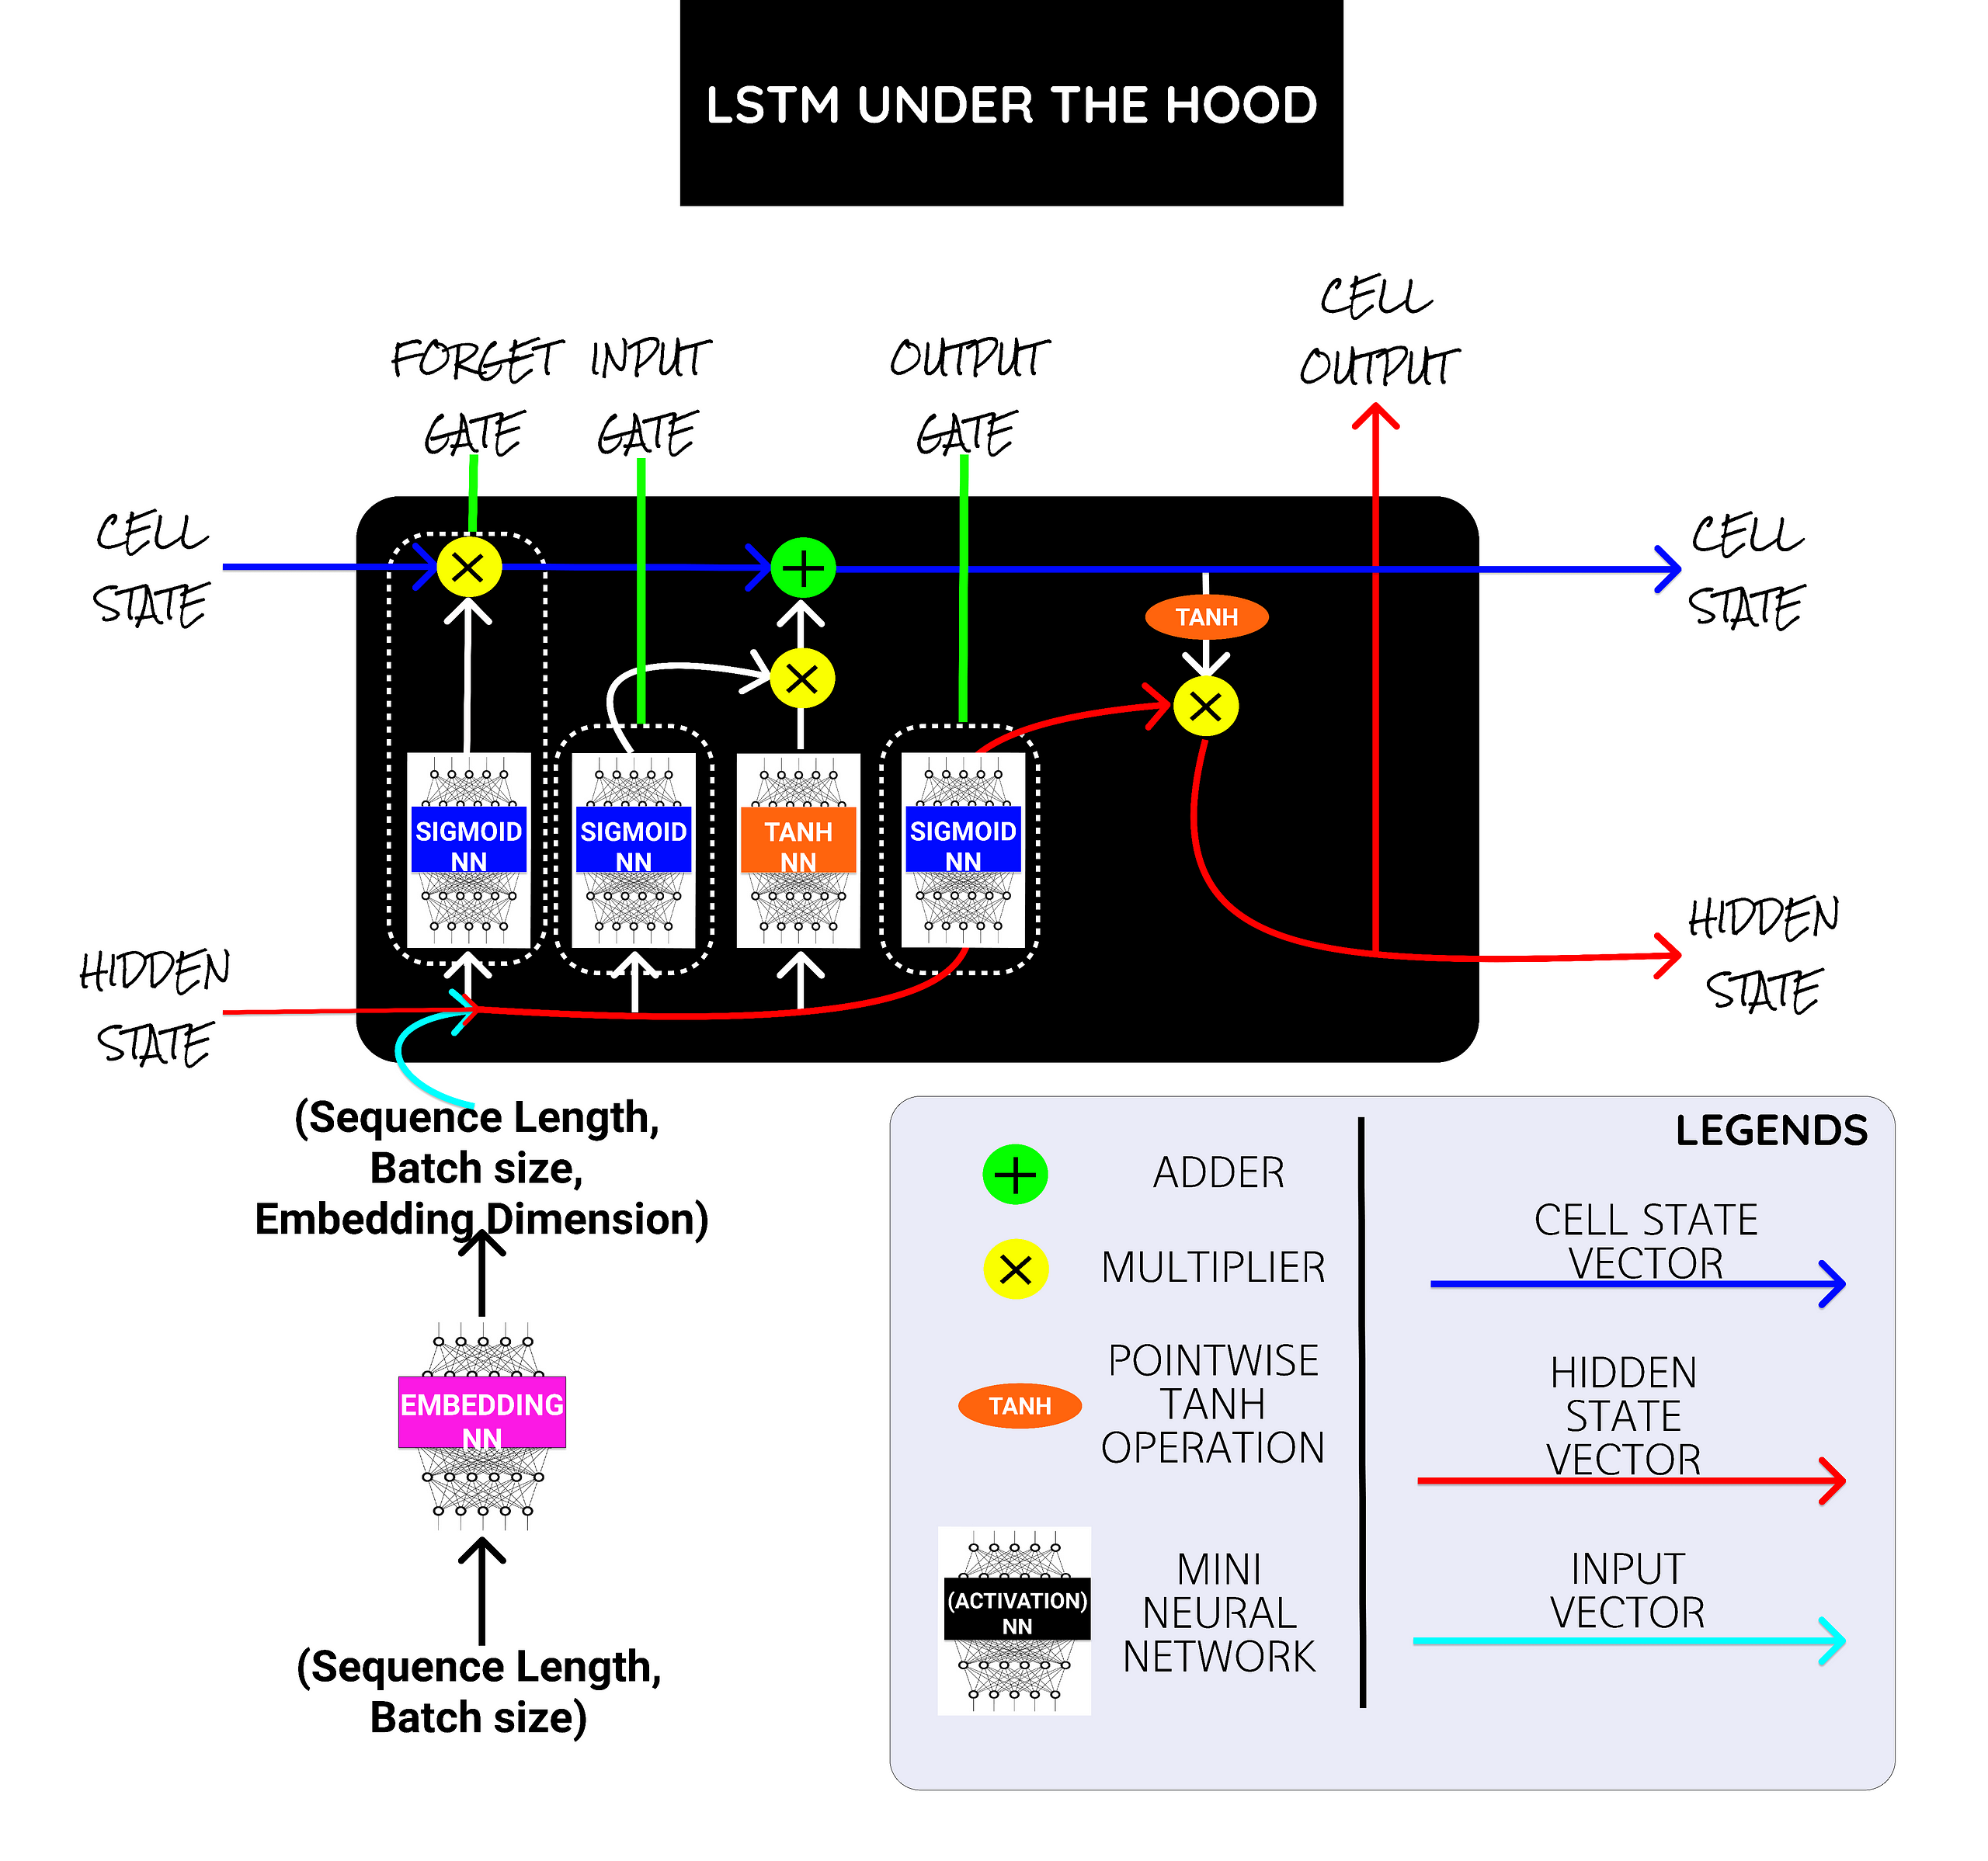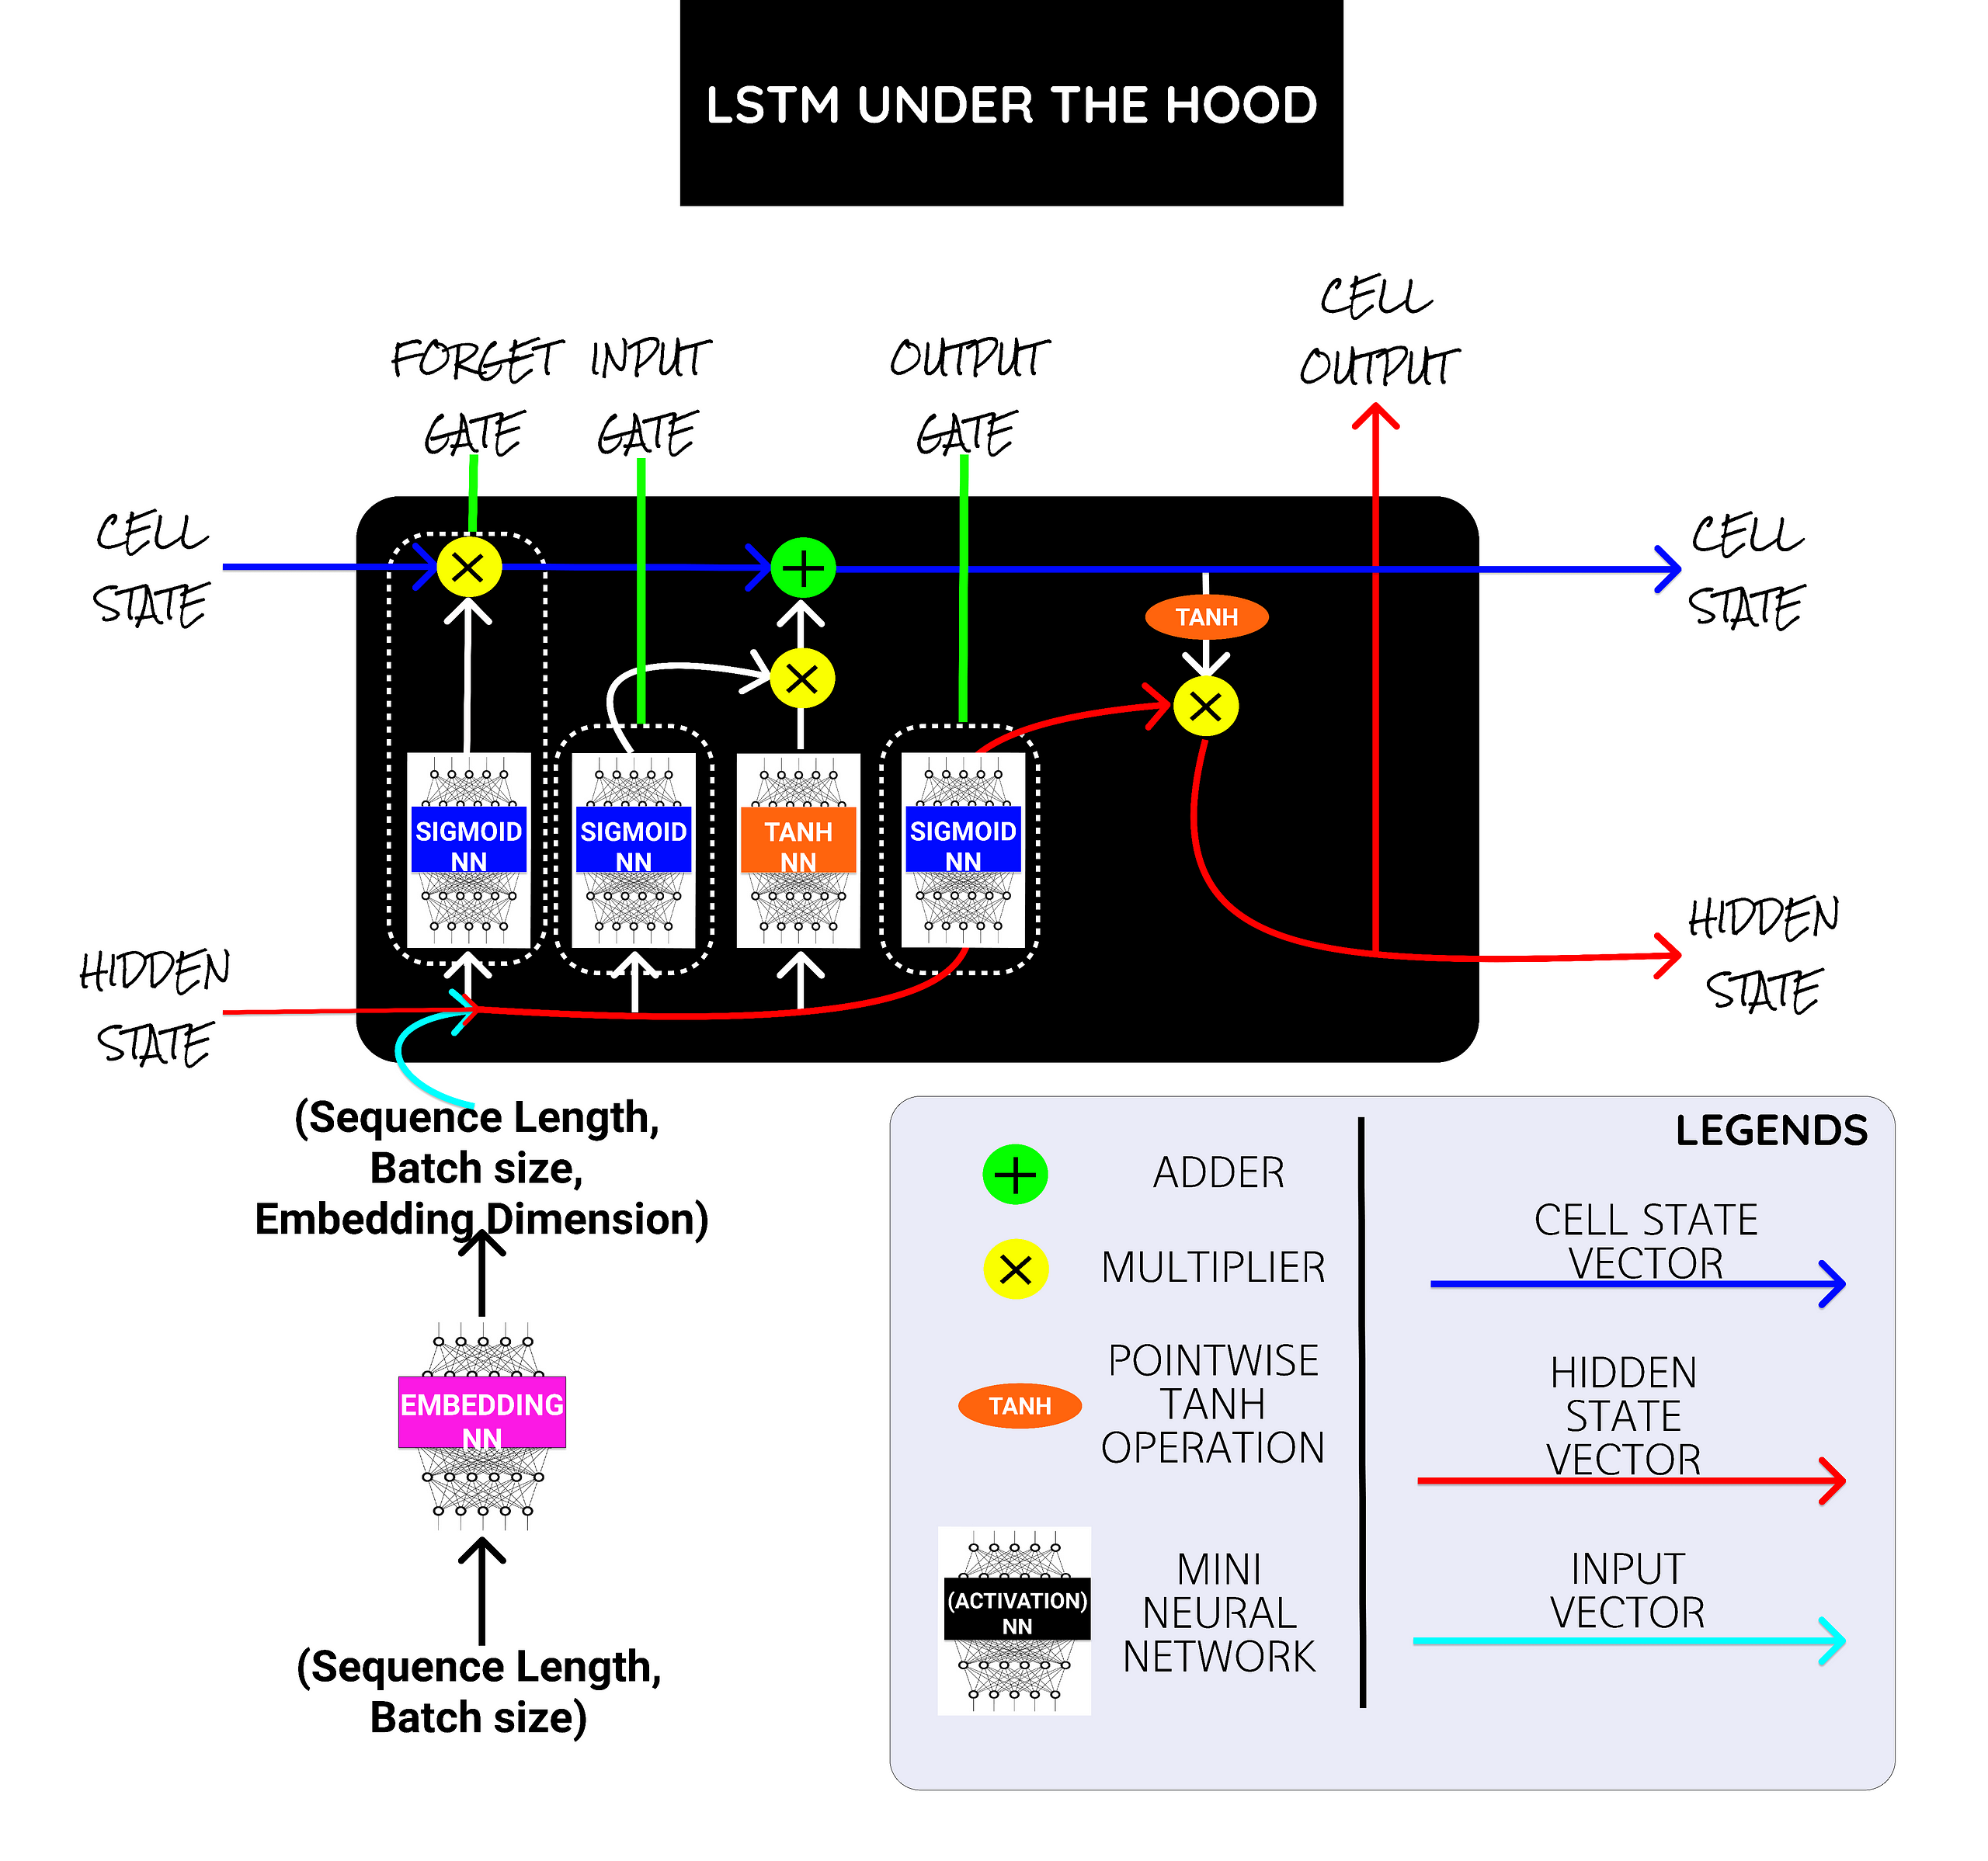
- TanH NN → Squishes the values between -1 and 1. Helps to regulate the vector values from either getting exploded to the maximum or shrank to the minimum.
- The hidden state and the cell state : the context vector

### 4. Encoder Model Architecture (Seq2Seq)

- Before moving to seq2seq model, we need to create Encoder ,Decoder and create a interface between them in the seq2seq model.
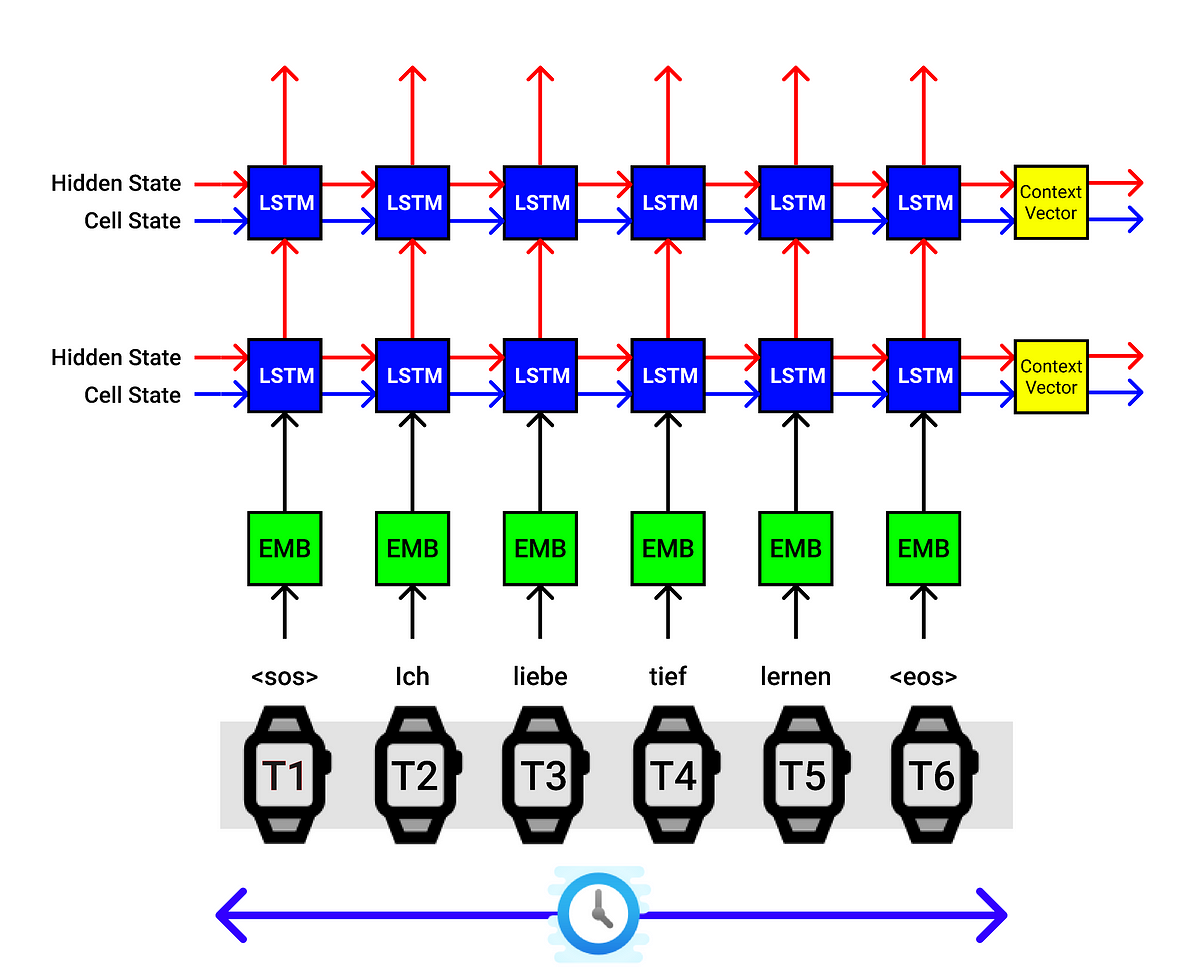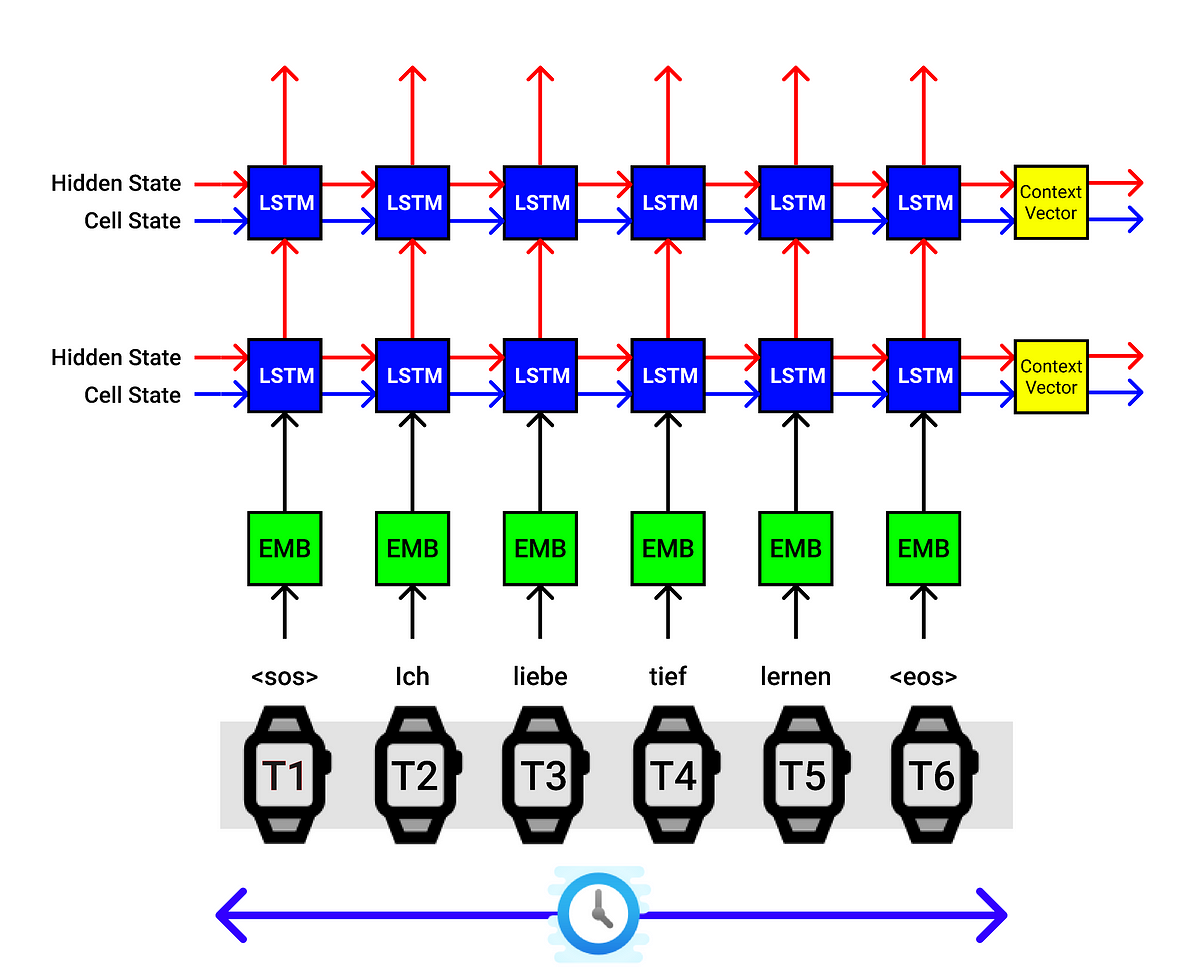
- start of sequence "SOS" and the end of sentence "EOS"
- word embedding layer [shown in green block], which converts the __input indexed word into a dense vector__ representation
- the hs and cs captured some vector representation of the sentence so far.
- At time step-0, the hidden state and cell state are either initialized fully of zeros or random numbers.
- 2 layer LSTM : obtain 2 context vectors stacked on top as the final output.
- Say we have a batch size of 5 (Experimental), then we pass 5 sentences at a time to the Encoder, which looks like the below figure.

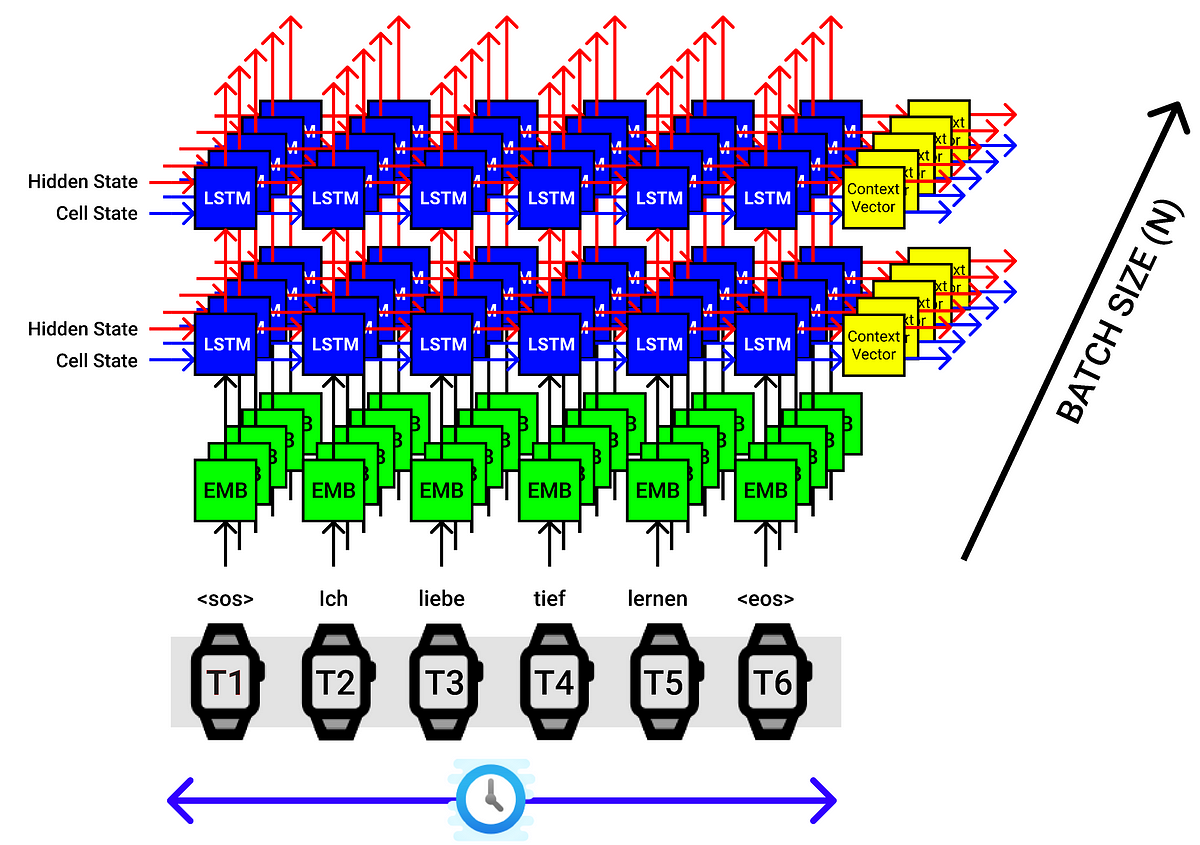
- a batch size of 5 (experimental), where we consider 5 input sentences and the first token from each sentences is sent to the encoder at a time. 

### 5. Encoder Code Implementation (Seq2Seq)

In [205]:
# 내가 따로 뺌
hidden_size = 1024
num_layers = 2 # 4
encoder_dropout = 0.5

In [245]:
class EncoderLSTM(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):
  # def __init__(..., src_embedding):
    super(EncoderLSTM, self).__init__()

    # Size of the one hot vectors that will be the input to the encoder 
    #  @one hot vec라기 보단 단어 사전 크기에서 각 단어에 해당하는 인덱스에 emb size만큼 dense 표현이 저장되어 있어서 one hot vec이라 한 듯
    #self.input_size = input_size

    # Output size of the word embedding NN
    #self.embedding_size = embedding_size

    # Dimension of the NN's inside the lstm cell/ (hs,cs)'s dimension.
    self.hidden_size = hidden_size

    # Number of layers in the lstm
    self.num_layers = num_layers

    # Regularization parameter
    self.dropout = nn.Dropout(p)
    self.tag = True # ?? 굳이 

    # Shape --------------------> (5376, 300) [input size, embedding dims]
    # if src_embedding is None:
    if flag_pretrained_emb :
        self.embedding = src_embedding # nn.LSTM(len(src_embedding[0]) 로 해야 더 안전할 듯
    else :
        self.embedding = nn.Embedding(input_size, embedding_size)
        
    # Shape -----------> (300, 2, 1024) [embedding dims, hidden size, num layers]
    self.LSTM = nn.LSTM(embedding_size, hidden_size, num_layers, dropout = p)

  # Shape of x (26, 32) [Sequence_length, batch_size]
  def forward(self, x):

    # Shape -----------> (26, 32, 300) [Sequence_length , batch_size , embedding dims]
    embedding = self.dropout(self.embedding(x))
    
    # Shape --> outputs (26, 32, 1024) [Sequence_length , batch_size , hidden_size]
    # Shape --> (hs, cs) (2, 32, 1024) , (2, 32, 1024) [num_layers, batch_size size, hidden_size]
    outputs, (hidden_state, cell_state) = self.LSTM(embedding)

    return hidden_state, cell_state

input_size_encoder = len(german.vocab)
encoder_embedding_size = 300 # len(src_embedding[0]) 로 해야 더 안전할 듯
# hidden_size = 1024
# num_layers = 2
encoder_dropout = 0.5

encoder_lstm = EncoderLSTM(input_size_encoder, encoder_embedding_size,
                           hidden_size, num_layers, encoder_dropout).to(device)
print(encoder_lstm)

EncoderLSTM(
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding): Embedding(10004, 300)
  (LSTM): LSTM(300, 1024, num_layers=2, dropout=0.5)
)


### 6. Decoder Model Architecture (Seq2Seq)

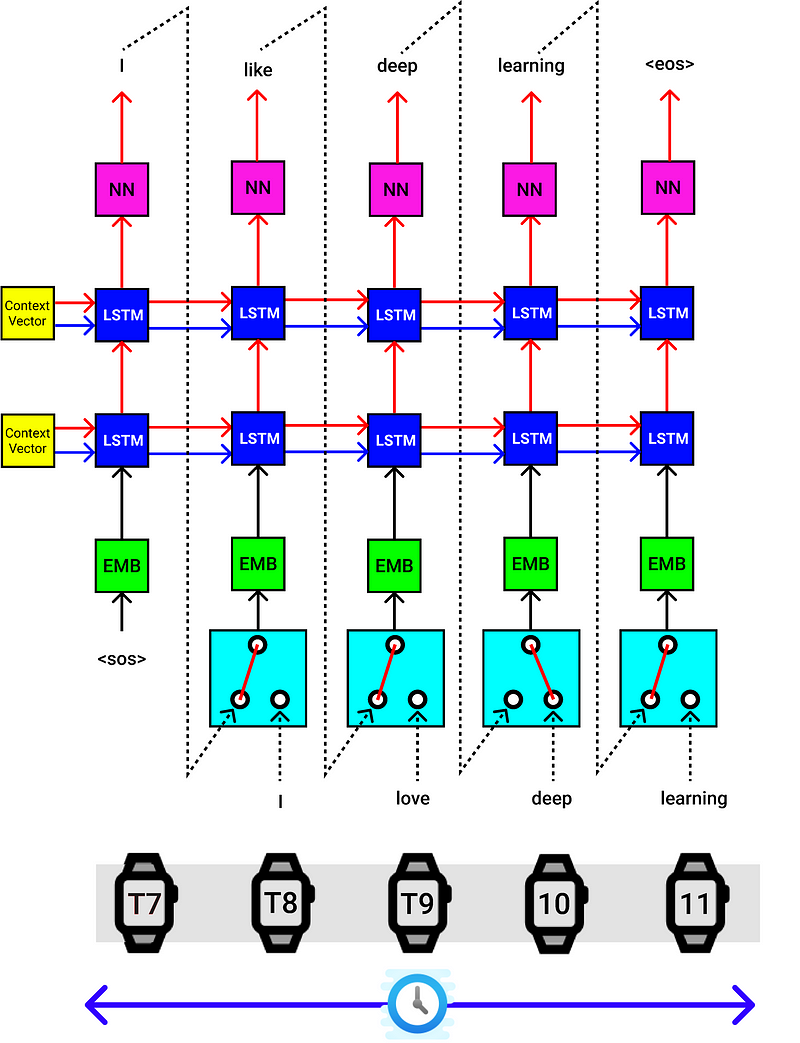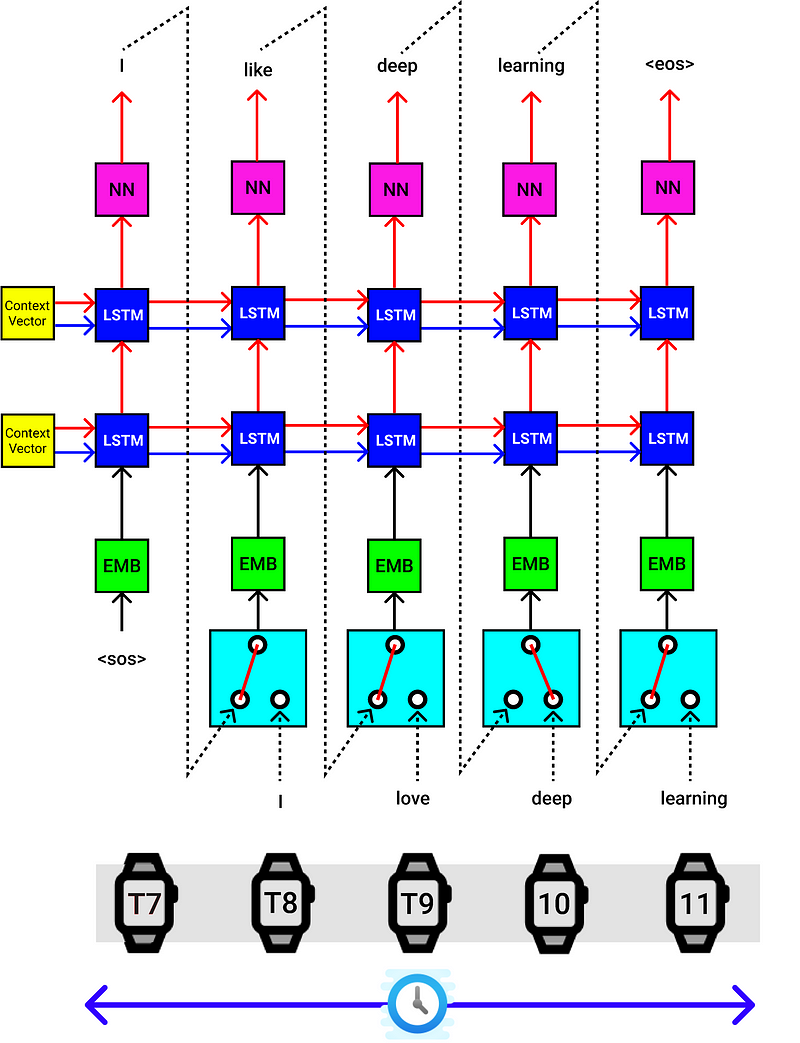
- finally, it is passed through a linear layer [Shown in Pink color], which provides an output English token prediction probabilities (4556 Probabilities), hidden state (hs), Cell State (cs). ?? fc가 왜 hs, cs를 제공한다는 거지
-  

### Teach Force Ratio:
- In addition to other blocks, you will also see the block shown below in the Decoder
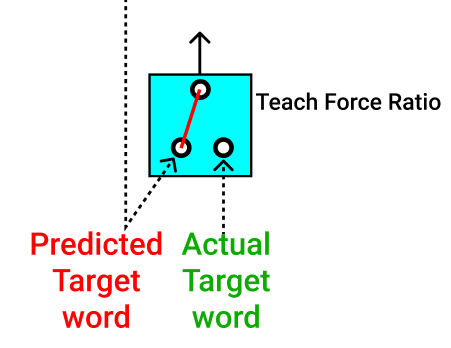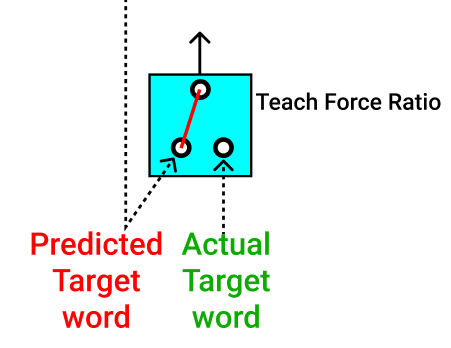
- Teach Force Ratio methodWe can send the actual target words to the decoder part while training (Shown in Green Color).
- We can also send the predicted target word, as the input to the decoder (Shown in Red Color).
- Whether sending either of the words (actual target or predicted target) can be regulated with a probability of 50%
- 

### 7. Decoder Code Implementation (Seq2Seq)

In [246]:
class DecoderLSTM(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, p, output_size):
  # def __init__(..., trg_embedding):
    super(DecoderLSTM, self).__init__()

    # Size of the one hot vectors that will be the input to the encoder
    #self.input_size = input_size

    # Output size of the word embedding NN
    #self.embedding_size = embedding_size

    # Dimension of the NN's inside the lstm cell/ (hs,cs)'s dimension.
    self.hidden_size = hidden_size

    # Number of layers in the lstm
    self.num_layers = num_layers

    # Size of the one hot vectors that will be the output to the encoder (English Vocab Size)
    self.output_size = output_size

    # Regularization parameter
    self.dropout = nn.Dropout(p)

    # Shape --------------------> (5376, 300) [input size, embedding dims]
    if flag_pretrained_emb :
        self.embedding = trg_embedding # nn.LSTM(len(tar_embedding[0]) 로 해야 안전할 듯
    else :        
        self.embedding = nn.Embedding(input_size, embedding_size)

    # Shape -----------> (300, 2, 1024) [embedding dims, hidden size, num layers]
    self.LSTM = nn.LSTM(embedding_size, hidden_size, num_layers, dropout = p)

    # Shape -----------> (1024, 4556) [embedding dims, hidden size, num layers] @ 잘못적은 듯 [h size, English Vocab Size]
    self.fc = nn.Linear(hidden_size, output_size)

  # Shape of x (32) [batch_size]
  def forward(self, x, hidden_state, cell_state):

    # Shape of x (1, 32) [1, batch_size]
    x = x.unsqueeze(0)

    # Shape -----------> (1, 32, 300) [1, batch_size, embedding dims]
    embedding = self.dropout(self.embedding(x))

    # Shape --> outputs (1, 32, 1024) [1, batch_size , hidden_size]
    # Shape --> (hs, cs) (2, 32, 1024) , (2, 32, 1024) [num_layers, batch_size size, hidden_size] (passing encoder's hs, cs - context vectors)
    outputs, (hidden_state, cell_state) = self.LSTM(embedding, (hidden_state, cell_state))

    # Shape --> predictions (1, 32, 4556) [ 1, batch_size , output_size]
    predictions = self.fc(outputs)

    # Shape --> predictions (32, 4556) [batch_size , output_size]
    predictions = predictions.squeeze(0)

    return predictions, hidden_state, cell_state

input_size_decoder = len(english.vocab)
decoder_embedding_size = 300 # len(tar_embedding[0]) 또는 tar_embedding.shape[1]로 해야 더 안전할 듯
# hidden_size = 1024
# num_layers = 2
decoder_dropout = 0.5
output_size = len(english.vocab)

decoder_lstm = DecoderLSTM(input_size_decoder, decoder_embedding_size,
                           hidden_size, num_layers, decoder_dropout, output_size).to(device)
print(decoder_lstm)

DecoderLSTM(
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding): Embedding(10004, 300)
  (LSTM): LSTM(300, 1024, num_layers=2, dropout=0.5)
  (fc): Linear(in_features=1024, out_features=10004, bias=True)
)


### 8. Seq2Seq (Encoder + Decoder) Interface

1. Provide both input (German) and output (English) sentences.
2. Pass the input sequence to the encoder and extract context vectors.
3. Pass the output sequence to the decoder, context vecotr from encoder to produce the predicted output sequence.

In [247]:
for batch in train_iterator:
  print(batch.src.shape)
  print(batch.trg.shape)
  break

x = batch.trg[1]
print(x)

torch.Size([88, 128])
torch.Size([100, 128])
tensor([  18, 1486,    4,  869,   78, 4102,   31,   43,   14,   34,   24,  257,
        2695,   31,    0,   22,    7,  303,   48,   37,    4,   12,    0,   25,
        1039,   14,   91,    4,  353,   11,    0,  536,   16,   23,    7,  184,
           4,   11,   31,    5,  147,   40,   11,   21,    4,   99,   18,    0,
          27,    7,   33, 3296,   25,  407,    4,    0,   14,   33,   52,    5,
          85,   67,    4,    4,   52,   11,  517,  166,   11,   24,   24, 2204,
          10,   33,   99,   10,   21,   18,  111,   11,   19,    4,   41,    5,
           9,    4,    5, 1574,    4,    7,    4,   40,    4,    4,  257,   12,
         160,  107,  264,   11,   90,   33,   21,    5,  653,    8,    8,   10,
         685,    8,   24,   10,    4,   10,   11,  120,  830,    7,   10,    0,
          10,    5,   33, 3189,   13,   25,    5,   21], device='cuda:0')


In [248]:
# batch.trg[0]

### 9. Seq2Seq (Encoder + Decoder) Code Implementation

In [249]:
# @Seq2Seq 코드만 바꿔도 encoder, decoder 다시 객체 생성해야 새롭게 훈련할 수 있음 
class Seq2Seq(nn.Module):
  def __init__(self, Encoder_LSTM, Decoder_LSTM):
    super(Seq2Seq, self).__init__()
    self.Encoder_LSTM = Encoder_LSTM
    self.Decoder_LSTM = Decoder_LSTM

  def forward(self, source, target, tfr=0.9): # tfr=0.5, 0.7, 0.9, 1.0
    # Shape - Source : (10, 32) [(Sentence length German + some padding), Number of Sentences]
    batch_size = source.shape[1]

    # Shape - Source : (14, 32) [(Sentence length English + some padding), Number of Sentences]
    target_len = target.shape[0]
    target_vocab_size = len(english.vocab)
    
    # Shape --> outputs (14, 32, 5766) 
    outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)

    # Shape --> (hs, cs) (2, 32, 1024) ,(2, 32, 1024) [num_layers, batch_size size, hidden_size] (contains encoder's hs, cs - context vectors)
    hidden_state, cell_state = self.Encoder_LSTM(source)

    # Shape of x (32 elements)
    x = target[0] # Trigger token <SOS>

    for i in range(1, target_len):
      # Shape --> output (32, 5766) 
      output, hidden_state, cell_state = self.Decoder_LSTM(x, hidden_state, cell_state)
      outputs[i] = output
      best_guess = output.argmax(1) # 0th dimension is batch size, 1st dimension is word embedding
      x = target[i] if random.random() < tfr else best_guess # Either pass the next word correctly from the dataset or use the earlier predicted word

    # Shape --> outputs (14, 32, 5766) 
    return outputs

__G SummaryWriter __
TensorBoard 시각화 도구와 함께 사용됨. 주로 모델 학습 중에 발생하는 다양한 지표들을 시각적으로 모니터링하고 디버깅하는 데 사용됩니다.

모델의 훈련 및 평가 중에 발생하는 정보를 기록합니다. 주로 다음과 같은 작업을 수행합니다:

1. 손실(loss) 및 성능 지표(metrics) 기록
1. 모델 파라미터 및 그래디언트 기록: 모델의 가중치(weight) 및 그래디언트를 시각화하여 학습 과정을 이해하고 모델의 개선 여부를 추적할 수 있습니다.
1. 이미지 및 텐서 기록: 훈련 중에 생성된 이미지, 텐서 등을 기록하여 시각화할 수 있습니다.
1. 학습 과정 모니터링: 학습 과정에서 발생하는 다양한 이벤트(예: 학습률 변화, 배치 처리 시간 등)를 기록하여 모델의 동작을 이해하고 최적화할 수 있습니다.

SummaryWriter를 사용하여 기록된 정보는 TensorBoard와 같은 시각화 도구를 사용하여 시각화

In [250]:
# Hyperparameters

learning_rate = 0.001
writer = SummaryWriter(f"runs/loss_plot")
step = 0

model = Seq2Seq(encoder_lstm, decoder_lstm).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

pad_idx = english.vocab.stoi["<pad>"]
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

In [251]:
model

Seq2Seq(
  (Encoder_LSTM): EncoderLSTM(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(10004, 300)
    (LSTM): LSTM(300, 1024, num_layers=2, dropout=0.5)
  )
  (Decoder_LSTM): DecoderLSTM(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(10004, 300)
    (LSTM): LSTM(300, 1024, num_layers=2, dropout=0.5)
    (fc): Linear(in_features=1024, out_features=10004, bias=True)
  )
)

In [252]:
# german.init_token # > '<sos>'
# test = [token.text.lower() for token in spacy_german("I am a boy")]
# test.insert(0, german.init_token)
# test # > ['<sos>', 'i', 'am', 'a', 'boy']

In [253]:
def translate_sentence(model, sentence, german, english, device, max_length=50):
    # spacy_ger = spacy.load("de_core_news_sm")
    spacy_ger = spacy.load("fr_core_news_sm")

    if type(sentence) == str:
        tokens = [token.text.lower() for token in spacy_ger(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    tokens.insert(0, german.init_token) # 기존 idx부터 한 칸씩 뒤로 밀려남
    tokens.append(german.eos_token)
    text_to_indices = [german.vocab.stoi[token] for token in tokens]
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)

    # Build encoder hidden, cell state
    with torch.no_grad():
        hidden, cell = model.Encoder_LSTM(sentence_tensor)

    outputs = [english.vocab.stoi["<sos>"]]

    for _ in range(max_length):
        previous_word = torch.LongTensor([outputs[-1]]).to(device)

        with torch.no_grad():
            output, hidden, cell = model.Decoder_LSTM(previous_word, hidden, cell)
            best_guess = output.argmax(1).item()

        outputs.append(best_guess)

        # Model predicts it's the end of the sentence
        if output.argmax(1).item() == english.vocab.stoi["<eos>"]:
            break

    translated_sentence = [english.vocab.itos[idx] for idx in outputs]
    return translated_sentence[1:]

def bleu(data, model, german, english, device, tqdm_flag=False):
    targets = []
    outputs = []

    if tqdm_flag :
        for example in tqdm(data): # desc="bleu"):
            # G vars()
            #  객체의 속성들을 딕셔너리 형태로 반환 ;객체의 __dict__ 속성을 반환
            #  객체의 __dict__ 속성은 해당 객체의 모든 속성을 담고 있는 딕셔너리
            src = vars(example)["src"]
            trg = vars(example)["trg"]
    
            prediction = translate_sentence(model, src, german, english, device)
            prediction = prediction[:-1]  # remove <eos> token
    
            targets.append([trg])
            outputs.append(prediction)
    else :
        for example in data:
            src = vars(example)["src"]
            trg = vars(example)["trg"]
    
            prediction = translate_sentence(model, src, german, english, device)
            prediction = prediction[:-1] 
    
            targets.append([trg])
            outputs.append(prediction)

    return bleu_score(outputs, targets)

def checkpoint_and_save(model, best_loss, epoch, optimizer, epoch_loss):
    print('saving')
    print()
    state = {'model': model,'best_loss': best_loss,'epoch': epoch,'rng_state': torch.get_rng_state(), 'optimizer': optimizer.state_dict(),}
    torch.save(state, '/data/hwyu/seq2seq/checkpoint-NMT')
    torch.save(model.state_dict(),'/data/hwyu/seq2seq/checkpoint-NMT-SD')

In [254]:
# example = test_data[4]
# vars(example)["src"]

# for data in train_data:
#     print(data.src)
#     # print("German - ",*data.src, " Length - ", len(data.src))
#     break
# train_data[0]

In [255]:
def evaluate(seq2seq, iterator, criterion):
    seq2seq.eval()

    epoch_loss = 0
    with torch.no_grad():
        for batch in iterator:
            # turn off teacher forcing
            outputs = seq2seq(batch.src, batch.trg, tfr=0) 

            # trg = [trg sent len, batch size]
            # output = [trg sent len, batch size, output dim]
            outputs_flatten = outputs[1:].view(-1, outputs.shape[-1])
            trg_flatten = batch.trg[1:].view(-1)
            loss = criterion(outputs_flatten, trg_flatten)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [256]:
# train_fr_sub[2000]
# train_en_sub[2000]
test_fr[54]
test_en[54]

'IT WOULD BE A BURNING SHAME UPON YOU EVEN NOW IF SHE AND I EXCHANGED A WORD'

In [257]:
losses = []
val_losses = []

In [ ]:
from tqdm import tqdm
import math

epoch_loss = 0.0
num_epochs = 60 # 100, 40, 35, 50, 60
best_loss = 999999
best_epoch = -1
bleus = []
best_bleu = 0.0

# sentence1 = "ein mann in einem blauen hemd steht auf einer leiter und putzt ein fenster"
# sentence1 = train_fr_sub[2000]
sentence1 = test_fr[54]
ts1  = []

for epoch in tqdm(range(num_epochs)):
  epo_loss = 0
  print("Epoch - {} / {}".format(epoch+1, num_epochs))

  # train_loss = train(seq2seq, train_iterator, optimizer, criterion) 로 따로 빼기 
  model.train(True)
  for batch_idx, batch in enumerate(train_iterator):
    input = batch.src.to(device)
    target = batch.trg.to(device)

    # Pass the input and target for model's forward method
    output = model(input, target)
    output = output[1:].reshape(-1, output.shape[2])
    target = target[1:].reshape(-1)

    # Clear the accumulating gradients
    optimizer.zero_grad()

    # Calculate the loss value for every epoch
    loss = criterion(output, target)

    # Calculate the gradients for weights & biases using back-propagation
    loss.backward()

    # Clip the gradient value is it exceeds > 1
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

    # Update the weights values using the gradients we calculated using bp 
    optimizer.step()
    step += 1
    epoch_loss += loss.item()
    epo_loss += loss.item()
    writer.add_scalar("Training loss", loss, global_step=step)
  
  # valid_loss = evaluate(model, valid_iterator, criterion)
  valid_loss = evaluate(model, test_iterator, criterion)
  
  # if epoch_loss < best_loss:
  #   best_loss = epoch_loss
  #   best_epoch = epoch
  #   checkpoint_and_save(model, best_loss, epoch, optimizer, epoch_loss) 
  #   if ((epoch - best_epoch) >= 10):
  #     print("no improvement in 10 epochs, break")
  #     break
  if valid_loss < best_loss:
        best_loss = valid_loss
        best_epoch = epoch
        # torch.save(seq2seq.state_dict(), '/data/hwyu/seq2seq/checkpoint-NMT-SD')
        checkpoint_and_save(model, best_loss, epoch, optimizer, epoch_loss) 
  # if ((epoch - best_epoch) >= 10):
  #     print("no improvement in 10 epochs, break")
  #     break
  # print("\tEpoch_Loss - {}".format(loss.item()))
  print()
  print(f'\tTrain Loss: {epo_loss/len(train_iterator):.3f} | Train PPL: {math.exp(epo_loss/len(train_iterator)):7.3f}')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
  losses.append(epo_loss/len(train_iterator))
  val_losses.append(valid_loss)
  
  if epoch % 4 == 3:
      model.eval()
      # translated_sentence1 = translate_sentence(model, sentence1, german, english, device, max_length=50)
      translated_sentence1 = translate_sentence(model, sentence1, german, english, device, max_length=limited_seq_length)
      print(f"Translated example sentence 1: \n {translated_sentence1}")
      ts1.append(translated_sentence1)
      
      score = bleu(test_data[1:100], model, german, english, device)
      print(f"\tBleu score {score*100:.3f}")
      if score > best_bleu:
          best_bleu = score
          torch.save(model.state_dict(), 'checkpoint-NMT-SD_best_bleu')
      bleus.append(score)
  
# print(epoch_loss / len(train_iterator)) # ?? 분모가 epoch * len(train_iterator) 아닌가 

  0%|                                                    | 0/45 [00:00<?, ?it/s]

Epoch - 1 / 45
saving



  2%|▉                                        | 1/45 [01:49<1:20:29, 109.77s/it]


	Train Loss: 5.595 | Train PPL: 269.120
	 Val. Loss: 5.604 |  Val. PPL: 271.567
Epoch - 2 / 45
saving



  4%|█▊                                       | 2/45 [03:37<1:17:43, 108.46s/it]


	Train Loss: 4.705 | Train PPL: 110.465
	 Val. Loss: 4.955 |  Val. PPL: 141.831
Epoch - 3 / 45
saving



  7%|██▋                                      | 3/45 [05:25<1:15:44, 108.21s/it]


	Train Loss: 4.162 | Train PPL:  64.196
	 Val. Loss: 4.742 |  Val. PPL: 114.613
Epoch - 4 / 45
saving


	Train Loss: 3.746 | Train PPL:  42.365
	 Val. Loss: 4.510 |  Val. PPL:  90.921
Translated example sentence 1: 
 ['it', 'would', 'be', 'a', 'very', '<unk>', 'to', 'me', 'for', 'you', 'as', 'if', 'i', 'am', 'with', 'a', '<unk>', '<eos>']
	Bleu score 5.902


  9%|███▋                                     | 4/45 [10:47<2:11:47, 192.87s/it]

Epoch - 5 / 45
saving



 11%|████▌                                    | 5/45 [12:38<1:48:44, 163.11s/it]


	Train Loss: 3.422 | Train PPL:  30.617
	 Val. Loss: 4.374 |  Val. PPL:  79.389
Epoch - 6 / 45
saving



 13%|█████▍                                   | 6/45 [14:29<1:34:36, 145.56s/it]


	Train Loss: 3.158 | Train PPL:  23.521
	 Val. Loss: 4.220 |  Val. PPL:  68.035
Epoch - 7 / 45


 16%|██████▍                                  | 7/45 [16:19<1:24:45, 133.84s/it]


	Train Loss: 2.936 | Train PPL:  18.834
	 Val. Loss: 4.257 |  Val. PPL:  70.616
Epoch - 8 / 45

	Train Loss: 2.748 | Train PPL:  15.606
	 Val. Loss: 4.321 |  Val. PPL:  75.267
Translated example sentence 1: 
 ['it', 'would', 'be', 'a', 'bad', 'thing', 'to', 'me', 'now', 'and', 'if', 'i', 'have', 'a', 'word', 'to', 'him', '<eos>']
	Bleu score 10.051


 18%|███████▎                                 | 8/45 [21:45<2:00:15, 195.00s/it]

Epoch - 9 / 45
saving



 20%|████████▏                                | 9/45 [23:36<1:41:21, 168.92s/it]


	Train Loss: 2.593 | Train PPL:  13.372
	 Val. Loss: 4.205 |  Val. PPL:  67.017
Epoch - 10 / 45
saving



 22%|████████▉                               | 10/45 [25:28<1:28:07, 151.07s/it]


	Train Loss: 2.453 | Train PPL:  11.623
	 Val. Loss: 4.186 |  Val. PPL:  65.780
Epoch - 11 / 45


 24%|█████████▊                              | 11/45 [27:17<1:18:25, 138.39s/it]


	Train Loss: 2.336 | Train PPL:  10.344
	 Val. Loss: 4.206 |  Val. PPL:  67.112
Epoch - 12 / 45

	Train Loss: 2.236 | Train PPL:   9.354
	 Val. Loss: 4.255 |  Val. PPL:  70.422
Translated example sentence 1: 
 ['it', 'would', 'be', 'a', 'bad', 'weakness', 'to', 'me', 'now', 'if', 'it', 'were', 'you', 'and', 'call', 'a', 'mistake', '<eos>']
	Bleu score 10.745


 27%|██████████▋                             | 12/45 [32:43<1:47:24, 195.29s/it]

Epoch - 13 / 45


 29%|███████████▌                            | 13/45 [34:32<1:30:14, 169.20s/it]


	Train Loss: 2.147 | Train PPL:   8.562
	 Val. Loss: 4.243 |  Val. PPL:  69.606
Epoch - 14 / 45


 31%|████████████▍                           | 14/45 [36:21<1:17:59, 150.94s/it]


	Train Loss: 2.055 | Train PPL:   7.808
	 Val. Loss: 4.264 |  Val. PPL:  71.114
Epoch - 15 / 45


 33%|█████████████▎                          | 15/45 [38:09<1:09:06, 138.21s/it]


	Train Loss: 1.984 | Train PPL:   7.273
	 Val. Loss: 4.386 |  Val. PPL:  80.352
Epoch - 16 / 45

	Train Loss: 1.923 | Train PPL:   6.843
	 Val. Loss: 4.309 |  Val. PPL:  74.349
Translated example sentence 1: 
 ['it', 'would', 'be', 'a', 'horrible', 'shame', 'to', 'see', 'you', 'now', 'if', 'she', 'has', 'been', 'a', 'word', 'and', 'gives', 'a', 'word', '<eos>']
	Bleu score 11.226


 36%|██████████████▏                         | 16/45 [43:35<1:34:03, 194.61s/it]

Epoch - 17 / 45


 38%|███████████████                         | 17/45 [45:23<1:18:38, 168.53s/it]


	Train Loss: 1.849 | Train PPL:   6.351
	 Val. Loss: 4.401 |  Val. PPL:  81.507
Epoch - 18 / 45


 40%|████████████████                        | 18/45 [47:12<1:07:47, 150.67s/it]


	Train Loss: 1.798 | Train PPL:   6.035
	 Val. Loss: 4.416 |  Val. PPL:  82.793
Epoch - 19 / 45


 42%|█████████████████▋                        | 19/45 [49:01<59:53, 138.21s/it]


	Train Loss: 1.746 | Train PPL:   5.731
	 Val. Loss: 4.393 |  Val. PPL:  80.864
Epoch - 20 / 45

	Train Loss: 1.699 | Train PPL:   5.468
	 Val. Loss: 4.421 |  Val. PPL:  83.140
Translated example sentence 1: 
 ['it', 'would', 'be', 'a', 'bad', 'thing', 'to', 'be', 'upon', 'me', 'now', 'as', 'she', 'has', 'and', 'put', 'me', 'a', 'word', '<eos>']
	Bleu score 12.224


 44%|█████████████████▊                      | 20/45 [54:30<1:21:25, 195.43s/it]

Epoch - 21 / 45


 47%|██████████████████▋                     | 21/45 [56:19<1:07:52, 169.69s/it]


	Train Loss: 1.651 | Train PPL:   5.210
	 Val. Loss: 4.433 |  Val. PPL:  84.169
Epoch - 22 / 45


 49%|████████████████████▌                     | 22/45 [58:10<58:14, 151.93s/it]


	Train Loss: 1.608 | Train PPL:   4.992
	 Val. Loss: 4.548 |  Val. PPL:  94.484
Epoch - 23 / 45


 51%|████████████████████▍                   | 23/45 [1:00:00<51:08, 139.46s/it]


	Train Loss: 1.573 | Train PPL:   4.819
	 Val. Loss: 4.570 |  Val. PPL:  96.545
Epoch - 24 / 45

	Train Loss: 1.535 | Train PPL:   4.640
	 Val. Loss: 4.593 |  Val. PPL:  98.795
Translated example sentence 1: 
 ['it', 'would', 'be', 'a', 'horrible', 'thing', 'upon', 'me', 'now', 'now', 'if', 'she', 'has', '<unk>', 'you', 'and', 'a', 'word', '<eos>']
	Bleu score 13.191


 53%|████████████████████▎                 | 24/45 [1:05:27<1:08:29, 195.70s/it]

Epoch - 25 / 45


 56%|██████████████████████▏                 | 25/45 [1:07:16<56:34, 169.73s/it]


	Train Loss: 1.494 | Train PPL:   4.457
	 Val. Loss: 4.628 |  Val. PPL: 102.278
Epoch - 26 / 45


 58%|███████████████████████                 | 26/45 [1:09:04<47:52, 151.19s/it]


	Train Loss: 1.466 | Train PPL:   4.333
	 Val. Loss: 4.704 |  Val. PPL: 110.406
Epoch - 27 / 45


 60%|████████████████████████                | 27/45 [1:10:54<41:35, 138.63s/it]


	Train Loss: 1.434 | Train PPL:   4.197
	 Val. Loss: 4.722 |  Val. PPL: 112.376
Epoch - 28 / 45

	Train Loss: 1.406 | Train PPL:   4.081
	 Val. Loss: 4.698 |  Val. PPL: 109.753
Translated example sentence 1: 
 ['it', 'would', 'be', 'a', 'bad', 'shame', 'upon', 'me', 'now', 'if', 'it', 'were', 'i', 'and', 'give', 'another', 'word', '<eos>']


 62%|████████████████████████▉               | 28/45 [1:16:21<55:19, 195.26s/it]

	Bleu score 12.415
Epoch - 29 / 45


 64%|█████████████████████████▊              | 29/45 [1:18:08<45:02, 168.91s/it]


	Train Loss: 1.379 | Train PPL:   3.970
	 Val. Loss: 4.771 |  Val. PPL: 118.028
Epoch - 30 / 45


 67%|██████████████████████████▋             | 30/45 [1:19:54<37:27, 149.85s/it]


	Train Loss: 1.354 | Train PPL:   3.871
	 Val. Loss: 4.792 |  Val. PPL: 120.523
Epoch - 31 / 45


 69%|███████████████████████████▌            | 31/45 [1:21:39<31:50, 136.45s/it]


	Train Loss: 1.331 | Train PPL:   3.787
	 Val. Loss: 4.873 |  Val. PPL: 130.773
Epoch - 32 / 45

	Train Loss: 1.306 | Train PPL:   3.691
	 Val. Loss: 4.914 |  Val. PPL: 136.177
Translated example sentence 1: 
 ['it', 'would', 'be', 'a', 'bad', 'thing', 'upon', 'me', 'now', 'if', 'it', 'were', 'i', 'and', 'given', 'it', 'a', 'word', '<eos>']


 71%|████████████████████████████▍           | 32/45 [1:27:04<41:48, 192.99s/it]

	Bleu score 12.868
Epoch - 33 / 45


 73%|█████████████████████████████▎          | 33/45 [1:28:53<33:32, 167.74s/it]


	Train Loss: 1.279 | Train PPL:   3.592
	 Val. Loss: 4.880 |  Val. PPL: 131.596
Epoch - 34 / 45


 76%|██████████████████████████████▏         | 34/45 [1:30:42<27:33, 150.34s/it]


	Train Loss: 1.266 | Train PPL:   3.548
	 Val. Loss: 4.872 |  Val. PPL: 130.538
Epoch - 35 / 45


 78%|███████████████████████████████         | 35/45 [1:32:30<22:54, 137.45s/it]


	Train Loss: 1.238 | Train PPL:   3.449
	 Val. Loss: 4.967 |  Val. PPL: 143.560
Epoch - 36 / 45

	Train Loss: 1.224 | Train PPL:   3.400
	 Val. Loss: 5.013 |  Val. PPL: 150.332
Translated example sentence 1: 
 ['it', 'would', 'be', 'a', 'bad', 'weakness', 'upon', 'me', 'now', 'if', 'you', 'and', 'i', 'have', 'given', 'a', 'word', '<eos>']
	Bleu score 14.111


 80%|████████████████████████████████        | 36/45 [1:37:55<29:03, 193.68s/it]

Epoch - 37 / 45


 82%|████████████████████████████████▉       | 37/45 [1:39:41<22:18, 167.30s/it]


	Train Loss: 1.205 | Train PPL:   3.338
	 Val. Loss: 4.966 |  Val. PPL: 143.514
Epoch - 38 / 45


 84%|█████████████████████████████████▊      | 38/45 [1:41:28<17:25, 149.29s/it]


	Train Loss: 1.187 | Train PPL:   3.277
	 Val. Loss: 5.021 |  Val. PPL: 151.597
Epoch - 39 / 45


 87%|██████████████████████████████████▋     | 39/45 [1:43:15<13:40, 136.77s/it]


	Train Loss: 1.168 | Train PPL:   3.215
	 Val. Loss: 5.121 |  Val. PPL: 167.548
Epoch - 40 / 45

	Train Loss: 1.156 | Train PPL:   3.177
	 Val. Loss: 5.133 |  Val. PPL: 169.561
Translated example sentence 1: 
 ['it', 'would', 'be', 'a', 'bad', 'thing', 'on', 'me', 'if', 'now', 'when', 'she', '<unk>', 'and', 'i', 'have', 'word', '<eos>']


 89%|███████████████████████████████████▌    | 40/45 [1:48:42<16:08, 193.75s/it]

	Bleu score 13.175
Epoch - 41 / 45


 91%|████████████████████████████████████▍   | 41/45 [1:50:29<11:10, 167.73s/it]


	Train Loss: 1.147 | Train PPL:   3.149
	 Val. Loss: 5.223 |  Val. PPL: 185.397
Epoch - 42 / 45


 93%|█████████████████████████████████████▎  | 42/45 [1:52:17<07:29, 149.69s/it]


	Train Loss: 1.121 | Train PPL:   3.068
	 Val. Loss: 5.178 |  Val. PPL: 177.345
Epoch - 43 / 45


 96%|██████████████████████████████████████▏ | 43/45 [1:54:04<04:33, 136.94s/it]


	Train Loss: 1.112 | Train PPL:   3.041
	 Val. Loss: 5.218 |  Val. PPL: 184.627
Epoch - 44 / 45

	Train Loss: 1.099 | Train PPL:   3.003
	 Val. Loss: 5.245 |  Val. PPL: 189.568
Translated example sentence 1: 
 ['that', 'would', 'be', 'a', 'bad', 'shame', 'upon', 'me', 'now', 'if', 'she', 'has', 'come', 'and', 'put', 'a', 'word', '<eos>']


In [274]:
print(f"best_valid_epoch : {best_epoch}")
print(f"best_bleu : {best_bleu*100:.3f}")

best_valid_epoch : 9
best_bleu : 14.111


In [275]:
torch.save(model.state_dict(), 'checkpoint-NMT-SD_final_epo')

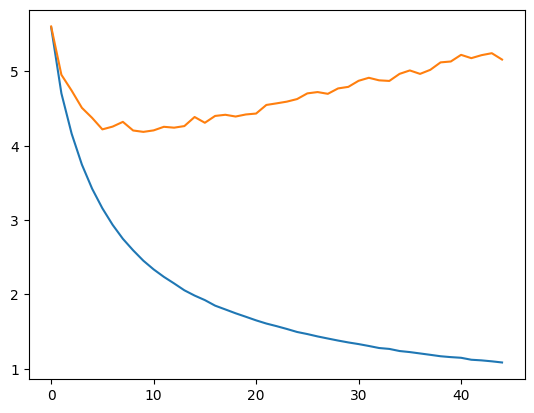

In [276]:
import matplotlib.pyplot as plt

losses_arr = np.array(losses)
val_losses_arr = np.array(val_losses)

plt.plot(losses_arr)
plt.plot(val_losses_arr)
plt.show()

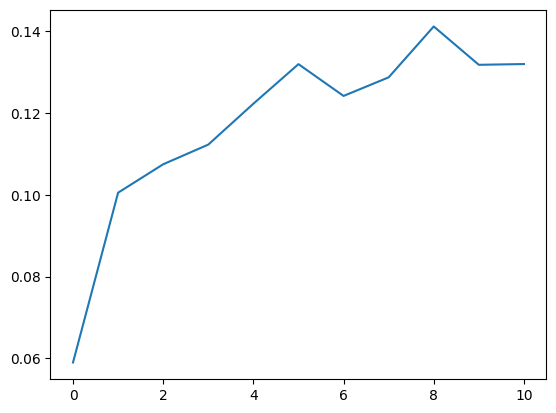

In [277]:
best_bleu_arr = np.array(bleus)

plt.plot(best_bleu_arr)
plt.show()

In [278]:
# !kill 38917
# %load_ext tensorboard 
# # %reload_ext tensorboard

# %tensorboard --logdir runs/
# # %tensorboard --logdir runs/ --port <port_number>

# 터미널 또는 명령 프롬프트에서 다음 명령을 실행
#   TensorBoard가 localhost의 기본 포트(일반적으로 6006)에서 실행
#   http://localhost:6006 (또는 TensorBoard가 실행된 포트)
#   TensorBoard를 열고 "Scalars" 탭을 선택하면 "Training loss"와 같은 이름의 그래프가 표시
# !tensorboard --logdir=runs

In [289]:
# %time score_all_test = bleu(test_data, model, german, english, device, tqdm_flag=True)
print(f"Bleu score {score_all_test*100:.3f}")

Bleu score 13.609


In [280]:
# %time score_sub_test = bleu(test_data[:1000], model, german, english, device)
# print(f"Bleu score {score_sub_test*100:.3f}")

In [281]:
loaded_model.load_state_dict(torch.load('checkpoint-NMT-SD_best_bleu'))
%time score_best_bleu = bleu(test_data, loaded_model, german, english, device, tqdm_flag=True)
print(f"Bleu score {score_best_bleu*100:.3f}")

  0%|                                        | 4/2048 [00:08<1:15:01,  2.20s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fad24a8ebf0>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
  0%|▏                                       | 7/2048 [00:15<1:15:41,  2.22s/it]

Bleu score 13.538




KeyboardInterrupt



#### Evaluating Seq2Seq

In [282]:
# 파일에서 상태를 로드합니다.
checkpoint = torch.load('checkpoint-NMT')

# 모델 아키텍처를 가져옵니다.
# loaded_model = checkpoint['model']

# 모델의 상태를 가져옵니다.
best_loss = checkpoint['best_loss']
epoch = checkpoint['epoch']
rng_state = checkpoint['rng_state']
optimizer_state_dict = checkpoint['optimizer']

# 모델에 상태를 불러옵니다.
# loaded_model.load_state_dict(model.state_dict())

# 옵티마이저를 초기화하고 불러온 상태를 설정합니다.
# optimizer = torch.optim.Adam(loaded_model.parameters())  # 이 부분은 사용하는 옵티마이저에 따라 다를 수 있습니다.
# optimizer.load_state_dict(optimizer_state_dict)

# 확인하는 코드
# print("Loaded model with architecture:", loaded_model)
print("Best loss:", best_loss)
print("Epoch:", epoch)

Best loss: 4.186317577958107
Epoch: 9


In [283]:
# model.load_state_dict(torch.load('checkpoint-NMT-SD'))

# test_loss = evaluate(model, test_iterator, criterion)
# print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

### 11. Seq2Seq Model Inference

In [284]:
progress  = []
import nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer
for i, sen in enumerate(ts1):
  progress.append(TreebankWordDetokenizer().detokenize(sen))
# print(progress)
# for sentence in progress:
#     print(sentence)

In [285]:
# progress_df = pd.DataFrame(data = progress, columns=['Predicted Sentence'])
# progress_df.index.name = "Epochs"
# progress_df.to_csv('/content/predicted_sentence.csv')
# progress_df.head()

In [286]:
print(test_en[41:44])
print()
print(test_fr[41:44])

['I NEVER COULD HAVE KEPT OUT OF IT A SINGLE WINTERS NIGHT IF I HAD NOT BEEN FREE OF ANY SHARE IN THAT', 'THE CAUSE OF HER FLIGHT IS TOO WELL UNDERSTOOD I SAID', 'YOU ARE INNOCENT OF ANY PART IN IT WE THOROUGHLY BELIEVE WE KNOW']

['Je n aurais jamais pu m arreter d une seule nuit d hiver si je n avais pas ete en mesure de partager ca', 'La cause de son vol est trop bien comprise dis je', 'Vous etes innocent de toute partie nous croyons sincerement nous le savons']


#### Model Inference

In [287]:
model.eval()
# test_sentences  = ["Zwei Männer gehen die Straße entlang", "Kinder spielen im Park.", "Diese Stadt verdient eine bessere Klasse von Verbrechern. Der Spaßvogel"]
# actual_sentences  = ["Two men are walking down the street", "Children play in the park", "This city deserves a better class of criminals. The joker"]
test_sentences  = test_fr[41:44] 
actual_sentences = test_en[41:44]
pred_sentences = []

for idx, i in enumerate(test_sentences):
  model.eval()
  # translated_sentence = translate_sentence(model, i, german, english, device, max_length=50)
  translated_sentence = translate_sentence(model, i, german, english, device, max_length=limited_seq_length)
  progress.append(TreebankWordDetokenizer().detokenize(translated_sentence))
  print("German : {}".format(i))
  print("Actual Sentence in English : {}".format(actual_sentences[idx]))
  print("Predicted Sentence in English : {}".format(progress[-1]))
  print()

German : Je n aurais jamais pu m arreter d une seule nuit d hiver si je n avais pas ete en mesure de partager ca
Actual Sentence in English : I NEVER COULD HAVE KEPT OUT OF IT A SINGLE WINTERS NIGHT IF I HAD NOT BEEN FREE OF ANY SHARE IN THAT
Predicted Sentence in English : i could never have suspected a moment of an hour night i had not been in any means to win that <eos>

German : La cause de son vol est trop bien comprise dis je
Actual Sentence in English : THE CAUSE OF HER FLIGHT IS TOO WELL UNDERSTOOD I SAID
Predicted Sentence in English : the cause of his work is too strong yet i said <eos>

German : Vous etes innocent de toute partie nous croyons sincerement nous le savons
Actual Sentence in English : YOU ARE INNOCENT OF ANY PART IN IT WE THOROUGHLY BELIEVE WE KNOW
Predicted Sentence in English : you are worthy of all we believe we know that <eos>



In [288]:
# 코드 변경시 에러 원인 가능성 
'''
dim=300

input_size_encoder = len(german.vocab)
encoder_embedding_size = 300 # len(src_embedding[0])
# hidden_size = 1024
# num_layers = 2
encoder_dropout = 0.5

self.embedding = src_embedding
self.LSTM = nn.LSTM(embedding_size # nn.LSTM(src_embedding[1] 로 해야 더 안전할 듯

self.embedding = trg_embedding # nn.LSTM(trg_embedding[1] 로 해야 안전할 듯
self.LSTM = nn.LSTM(embedding_size

input_size_decoder = len(english.vocab)
decoder_embedding_size = 300 # len(tar_embedding[0]) 또는 tar_embedding.shape[1]로 해야 더 안전할 듯
# hidden_size = 1024
# num_layers = 2
decoder_dropout = 0.5
output_size = len(english.vocab)

target_vocab_size = len(english.vocab)
'''

# 데이터 변경시 성능 저하 우려 
'''
max_size=10000, min_freq=3

max_length=50 -> max_length=limited_seq_length

spacy_ger = spacy.load("de_core_news_sm") # 그냥 spacy_german 이거 쓰면 되잖아 
'''

''' 하드 코딩
[str("S_")+str(x) for x in np.arange(1, 33)]) -> 33 대신 BATCH_SIZE+1 

# sentence1 = "ein mann in einem blauen hemd steht auf einer leiter und putzt ein fenster"

test_sentences  = ["Zwei Männer gehen die Straße entlang", "Kinder spielen im Park.", "Diese Stadt verdient eine bessere Klasse von Verbrechern. Der Spaßvogel"]
actual_sentences  = ["Two men are walking down the street", "Children play in the park", "This city deserves a better class of criminals. The joker"]
'''

' 하드 코딩\n[str("S_")+str(x) for x in np.arange(1, 33)]) -> 33 대신 BATCH_SIZE+1 \n\n# sentence1 = "ein mann in einem blauen hemd steht auf einer leiter und putzt ein fenster"\n\ntest_sentences  = ["Zwei Männer gehen die Straße entlang", "Kinder spielen im Park.", "Diese Stadt verdient eine bessere Klasse von Verbrechern. Der Spaßvogel"]\nactual_sentences  = ["Two men are walking down the street", "Children play in the park", "This city deserves a better class of criminals. The joker"]\n'